# Synthetic Data Simulation for High-Dimensional Shrinkage Research

**Purpose:** Generate controlled synthetic datasets spanning 10 distinct statistical regimes to benchmark Bayesian and Frequentist regularisation methods.

**Why synthetic simulation matters for shrinkage research:**

- Real datasets conflate multiple effects (correlation, sparsity, noise structure) making it hard to isolate _why_ a method succeeds or fails.
- Synthetic DGPs let us control **exactly one axis** at a time and observe phase transitions in estimator behaviour.
- Key axes of variation: **sparsity level**, **signal-to-noise ratio**, **p/n ratio**, **correlation structure**, **noise distribution**, **signal geometry**.

**Methods under study:**
| Method | Prior / Penalty | Sparsity | Grouping | Robustness |
|---|---|---|---|---|
| **Lasso** | $\ell_1$ penalty | ✅ Hard threshold | ❌ Picks one from group | ❌ Squared loss |
| **Ridge** | $\ell_2$ penalty | ❌ Shrinks all | ✅ Stable under collinearity | ❌ Squared loss |
| **Elastic Net** | $\alpha\ell_1 + (1-\alpha)\ell_2$ | Moderate | Partial grouping | ❌ Squared loss |
| **Bayesian Lasso** | Laplace prior $\pi(\beta_j) \propto e^{-\lambda|\beta_j|}$ | Moderate | ❌ | ❌ Gaussian likelihood |
| **Horseshoe** | $\beta_j | \lambda_j \sim N(0,\tau^2\lambda_j^2)$, $\lambda_j \sim C^+(0,1)$ | ✅ Near-optimal | ❌ | ❌ Gaussian likelihood |

---

### Scenarios Implemented

1. True Sparse Signal (canonical Lasso setting)
2. Correlated Feature Groups (latent factor model)
3. Dense Signal (Ridge-favourable regime)
4. Weak Signal / Low SNR
5. Ultra High-Dimensional ($p \gg n$)
6. Block Correlation Structure
7. Heavy-Tailed Noise
8. Heteroskedastic Noise
9. Non-Gaussian Feature Distributions
10. Structured (Group / Hierarchical) Sparsity


---

## 1 · Imports and Global Configuration


In [1]:
# ============================================================
# Section 1 — Imports and Global Configuration
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats, linalg
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA, TruncatedSVD
import os
import itertools
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# ── Global configuration ──────────────────────────────────────
CONFIG = {
    'n': 100,                    # Default sample size
    'p': 500,                    # Default feature dimension
    'k': 10,                     # Default active features
    'signal_strength': 1.0,      # Default coefficient magnitude scale
    'noise_std': 1.0,            # Default noise standard deviation
    'correlation_strength': 0.8, # Default correlation within groups
    'seed': 42,                  # Master random seed
    'output_dir': './synthetic_data/',  # Export directory
}

SEED = CONFIG['seed']
np.random.seed(SEED)

# ── Plotting defaults ─────────────────────────────────────────
plt.rcParams.update({
    'figure.figsize': (14, 6),
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'font.size': 10,
    'legend.fontsize': 9,
    'figure.dpi': 120,
    'savefig.dpi': 150,
    'axes.spines.top': False,
    'axes.spines.right': False,
})
sns.set_style('whitegrid')

# ── Scenario colour palette ───────────────────────────────────
SCENARIO_COLORS = {
    'True Sparse':         '#1f77b4',
    'Correlated Groups':   '#ff7f0e',
    'Dense Signal':        '#2ca02c',
    'Weak Signal':         '#d62728',
    'Ultra High-Dim':      '#9467bd',
    'Block Correlation':   '#8c564b',
    'Heavy-Tailed Noise':  '#e377c2',
    'Heteroskedastic':     '#7f7f7f',
    'Non-Gaussian X':      '#bcbd22',
    'Structured Sparsity': '#17becf',
}

print(f"Config: n={CONFIG['n']}, p={CONFIG['p']}, k={CONFIG['k']}, seed={SEED}")
print(f"Output directory: {os.path.abspath(CONFIG['output_dir'])}")
print("Environment ready. ✅")

Config: n=100, p=500, k=10, seed=42
Output directory: d:\Bayesian Regresion\Lasso\synthetic_data
Environment ready. ✅


---

## 2 · Core Simulation Utilities and Diagnostic Metrics

Every scenario returns a standardised result dictionary containing `X`, `y`, `beta_true`, and a full diagnostics sub-dictionary. The metrics computed for each dataset:

| Metric                             | Formula / Definition                                                          | Why it matters                                             |
| ---------------------------------- | ----------------------------------------------------------------------------- | ---------------------------------------------------------- |
| **SNR**                            | $\text{Var}(X\beta) / \sigma^2_\varepsilon$                                   | Determines if _any_ method can recover signal              |
| **Condition number** $\kappa$      | $\sigma_{\max} / \sigma_{\min}$ of $X$                                        | High $\kappa$ ⟹ collinearity ⟹ Ridge helps, Lasso unstable |
| **Effective rank**                 | $\exp\!\bigl(-\sum p_i \log p_i\bigr)$ where $p_i = \sigma_i / \sum \sigma_j$ | Intrinsic dimensionality of $X$                            |
| **Sparsity fraction**              | $\|\\{\beta_j = 0\\}\| / p$                                                   | Determines Lasso vs Ridge advantage                        |
| **Mean $\lvert\text{corr}\rvert$** | Average off-diagonal $\lvert r_{jk}\rvert$                                    | High correlation ⟹ Lasso selection unstable                |
| **Gini index**                     | Inequality measure on $\lvert\beta\rvert$                                     | Captures signal concentration                              |


In [2]:
# ============================================================
# Section 2 — Core Simulation Utilities
# ============================================================

def compute_snr(X, beta, noise_std):
    """Signal-to-noise ratio: Var(Xβ) / σ²_ε.
    
    High SNR → easy recovery for all methods.
    Low SNR  → tests false-positive control; Horseshoe's
               adaptive shrinkage can outperform Lasso here.
    """
    signal = X @ beta
    return np.var(signal) / (noise_std ** 2)


def compute_sparsity_metrics(beta):
    """Compute sparsity-related statistics on coefficient vector.
    
    - zero_frac: fraction of exactly-zero β_j (higher = more sparse)
    - gini: Gini index of |β| — 1.0 = maximally concentrated signal
    - L1/L2: norm ratio; small → sparse, large → dense
    """
    abs_beta = np.abs(beta)
    p = len(beta)
    n_nonzero = np.sum(abs_beta > 1e-12)
    zero_frac = 1.0 - n_nonzero / p

    # Gini index on |β|
    sorted_b = np.sort(abs_beta)
    n = len(sorted_b)
    if np.sum(sorted_b) > 0:
        index = np.arange(1, n + 1)
        gini = (2 * np.sum(index * sorted_b) / (n * np.sum(sorted_b))) - (n + 1) / n
    else:
        gini = 0.0

    return {
        'n_nonzero': int(n_nonzero),
        'n_zero': int(p - n_nonzero),
        'zero_frac': round(zero_frac, 4),
        'L1_norm': round(float(np.sum(abs_beta)), 4),
        'L2_norm': round(float(np.sqrt(np.sum(beta ** 2))), 4),
        'gini': round(float(gini), 4),
    }


def compute_correlation_metrics(X, max_features=200):
    """Correlation structure of design matrix.
    
    High mean |corr| → Lasso selection unstable (irrepresentable
    condition likely violated); Elastic Net grouping effect helps;
    Ridge prediction stable.
    """
    n, p = X.shape
    if p > max_features:
        idx = np.sort(np.random.choice(p, max_features, replace=False))
        X_sub = X[:, idx]
    else:
        X_sub = X

    corr = np.corrcoef(X_sub.T)
    corr = np.nan_to_num(corr)
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    off_diag = np.abs(corr[mask])

    return {
        'mean_abs_corr': round(float(np.mean(off_diag)), 4),
        'max_abs_corr': round(float(np.max(off_diag)) if len(off_diag) > 0 else 0.0, 4),
        'median_abs_corr': round(float(np.median(off_diag)), 4),
        'corr_matrix': corr,
    }


def compute_condition_and_rank(X):
    """Condition number and effective rank from SVD.
    
    - Condition number κ = σ_max / σ_min.  κ → ∞ means rank-deficient
      design; OLS impossible, penalisation essential.
    - Effective rank (Shannon entropy definition) captures intrinsic
      dimensionality regardless of nominal p.
    """
    try:
        sv = np.linalg.svd(X, compute_uv=False)
    except np.linalg.LinAlgError:
        k = min(min(X.shape) - 1, 300)
        tsvd = TruncatedSVD(n_components=k, random_state=SEED)
        tsvd.fit(X)
        sv = tsvd.singular_values_

    sv_pos = sv[sv > 1e-12]
    cond = float(sv_pos[0] / sv_pos[-1]) if len(sv_pos) > 1 else np.inf

    # Effective rank via Shannon entropy
    p_i = sv_pos / np.sum(sv_pos)
    p_i = p_i[p_i > 0]
    eff_rank = float(np.exp(-np.sum(p_i * np.log(p_i))))

    # Cumulative variance explained
    eig = sv ** 2
    cum_var = np.cumsum(eig) / np.sum(eig) if np.sum(eig) > 0 else np.zeros_like(eig)
    intrinsic_dim = int(np.searchsorted(cum_var, 0.90) + 1)

    return {
        'condition_number': round(cond, 2) if not np.isinf(cond) else np.inf,
        'effective_rank': round(eff_rank, 2),
        'intrinsic_dim_90': intrinsic_dim,
        'singular_values': sv,
        'cum_var_explained': cum_var,
    }


def generate_response(X, beta, noise_std, rng=None):
    """y = Xβ + ε,  ε ~ N(0, σ²I)."""
    if rng is None:
        rng = np.random.default_rng(SEED)
    n = X.shape[0]
    epsilon = rng.normal(0, noise_std, size=n)
    y = X @ beta + epsilon
    return y, epsilon


def compute_all_diagnostics(X, beta, noise_std, epsilon=None):
    """Consolidated diagnostic dictionary for any scenario."""
    snr = compute_snr(X, beta, noise_std)
    sp = compute_sparsity_metrics(beta)
    corr = compute_correlation_metrics(X)
    cond = compute_condition_and_rank(X)

    diag = {
        'n': X.shape[0],
        'p': X.shape[1],
        'p_over_n': round(X.shape[1] / X.shape[0], 3),
        'SNR': round(snr, 4),
        **sp,
        'mean_abs_corr': corr['mean_abs_corr'],
        'max_abs_corr': corr['max_abs_corr'],
        'condition_number': cond['condition_number'],
        'effective_rank': cond['effective_rank'],
        'intrinsic_dim_90': cond['intrinsic_dim_90'],
    }
    # Store arrays for plotting (not serialisable)
    diag['_sv'] = cond['singular_values']
    diag['_cum_var'] = cond['cum_var_explained']
    diag['_corr_matrix'] = corr['corr_matrix']

    return diag


def print_diagnostics(diag, name):
    """Pretty-print the diagnostic dict."""
    print(f"\n{'='*60}")
    print(f"  {name}")
    print(f"{'='*60}")
    skip = {'_sv', '_cum_var', '_corr_matrix'}
    for k, v in diag.items():
        if k in skip:
            continue
        if isinstance(v, float):
            print(f"  {k:25s}: {v:>12.4f}")
        else:
            print(f"  {k:25s}: {v!s:>12s}")
    print(f"{'='*60}\n")


# ── Collector for cross-scenario comparison ───────────────────
ALL_SCENARIOS = {}   # name → {X, y, beta, diag, params}

print("Core utilities defined. ✅")

Core utilities defined. ✅


---
## 3 · Scenario Generators

Each generator returns a standardised dict: `{'X': ndarray, 'y': ndarray, 'beta': ndarray, 'diag': dict, 'params': dict}`.

---

### 3.1 — True Sparse Signal (Canonical Lasso Setting)

**DGP:** $X \sim \mathcal{N}(0, I_p)$, $\beta = (\beta_1 \ldots \beta_k, 0 \ldots 0)$, $y = X\beta + \varepsilon$

**Why it matters:** This is the textbook scenario where Lasso should excel — the $\ell_1$ penalty's geometry (diamond constraint set) promotes _exactly_ sparse solutions, matching the true DGP.

**Expected behaviour:**

- **Lasso:** Near-optimal support recovery when irrepresentable condition holds (satisfied here since $X$ has iid columns).
- **Horseshoe:** Excellent — heavy Cauchy tails preserve large signals while the global shrinkage parameter $\tau$ adapts to overall sparsity.
- **Ridge:** Poor variable selection — shrinks all coefficients toward zero uniformly, never zeroing any out.
- **Bayesian Lasso:** Moderate — Laplace prior provides continuous shrinkage but less aggressive selection than Horseshoe.
- **Elastic Net:** Slightly worse than Lasso when features are truly independent (the $\ell_2$ component adds unnecessary bias).



  Scenario 1: True Sparse Signal
  n                        :          100
  p                        :          500
  p_over_n                 :       5.0000
  SNR                      :      21.5160
  n_nonzero                :           10
  n_zero                   :          490
  zero_frac                :       0.9800
  L1_norm                  :      13.9376
  L2_norm                  :       4.5808
  gini                     :       0.9832
  mean_abs_corr            :       0.0803
  max_abs_corr             :       0.3968
  condition_number         :       2.5300
  effective_rank           :      97.3400
  intrinsic_dim_90         :           79



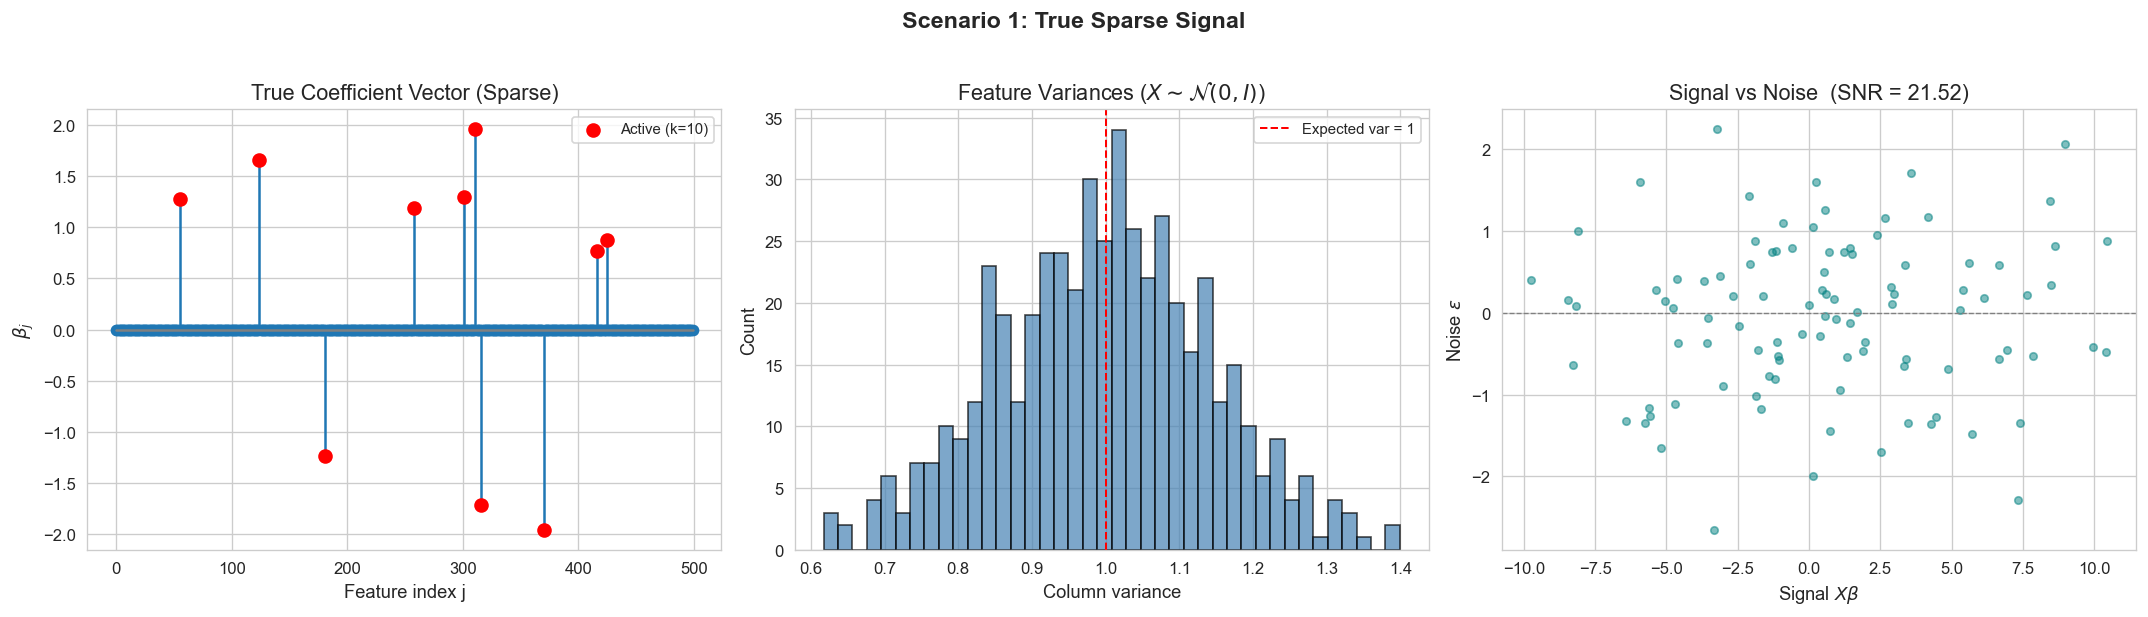

In [4]:
# ============================================================
# 3.1 — True Sparse Signal
# ============================================================

def generate_true_sparse(n=100, p=500, k=10, signal_strength=1.0,
                         noise_std=1.0, seed=42):
    """Canonical sparse regression: k active features, p-k exactly zero.
    
    Non-zero β_j ~ Uniform([0.5, 2.0]) × random sign, scaled by signal_strength.
    """
    rng = np.random.default_rng(seed)
    
    # Design matrix: iid standard normal
    X = rng.standard_normal((n, p))
    
    # Sparse coefficient vector
    beta = np.zeros(p)
    active_idx = rng.choice(p, k, replace=False)
    magnitudes = rng.uniform(0.5, 2.0, size=k)
    signs = rng.choice([-1, 1], size=k)
    beta[active_idx] = signal_strength * magnitudes * signs
    
    # Response
    y, epsilon = generate_response(X, beta, noise_std, rng)
    
    # Diagnostics
    diag = compute_all_diagnostics(X, beta, noise_std, epsilon)
    params = dict(n=n, p=p, k=k, signal_strength=signal_strength,
                  noise_std=noise_std, seed=seed)
    
    result = {'X': X, 'y': y, 'beta': beta, 'diag': diag,
              'params': params, 'active_idx': active_idx}
    return result


# ── Generate and visualise ────────────────────────────────────
res1 = generate_true_sparse(**{k: CONFIG[k] for k in ['n', 'p', 'k', 'signal_strength', 'noise_std', 'seed']})
print_diagnostics(res1['diag'], 'Scenario 1: True Sparse Signal')
ALL_SCENARIOS['True Sparse'] = res1

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) True β stem plot
ax = axes[0]
ax.stem(np.arange(len(res1['beta'])), res1['beta'], linefmt='C0-', markerfmt='C0o',
        basefmt='grey')
ax.scatter(res1['active_idx'], res1['beta'][res1['active_idx']],
           color='red', s=60, zorder=5, label=f'Active (k={len(res1["active_idx"])})')
ax.set_xlabel('Feature index j')
ax.set_ylabel(r'$\beta_j$')
ax.set_title('True Coefficient Vector (Sparse)')
ax.legend()

# (b) Column variances → verify isotropy
ax = axes[1]
col_vars = np.var(res1['X'], axis=0)
ax.hist(col_vars, bins=40, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(1.0, color='red', ls='--', lw=1.2, label='Expected var = 1')
ax.set_xlabel('Column variance')
ax.set_ylabel('Count')
ax.set_title(r'Feature Variances ($X \sim \mathcal{N}(0, I)$)')
ax.legend()

# (c) Signal vs noise
ax = axes[2]
signal = res1['X'] @ res1['beta']
noise = res1['y'] - signal
ax.scatter(signal, noise, alpha=0.5, s=20, c='teal')
ax.axhline(0, color='grey', ls='--', lw=0.8)
ax.set_xlabel(r'Signal $X\beta$')
ax.set_ylabel(r'Noise $\varepsilon$')
ax.set_title(f'Signal vs Noise  (SNR = {res1["diag"]["SNR"]:.2f})')

plt.suptitle('Scenario 1: True Sparse Signal', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.2 — Correlated Feature Groups (Latent Factor Model)

**DGP:** For each group $g$, generate latent factor $Z_g \sim \mathcal{N}(0, I_n)$, then
$$X_j = \rho \, Z_g + \sqrt{1 - \rho^2}\,\delta_j, \quad \delta_j \sim \mathcal{N}(0, I_n)$$
Features outside groups are iid $\mathcal{N}(0,1)$.

**Why it matters:**

- **Lasso** tends to pick _one_ feature from a correlated group arbitrarily (irrepresentable condition violated within groups).
- **Elastic Net** grouping effect: the $\ell_2$ component encourages correlated features to enter the model together.
- **Horseshoe** handles multicollinearity via continuous shrinkage — posterior mass spreads across correlated predictors.
- **Ridge** gives stable prediction but no variable selection.



  Scenario 2: Correlated Feature Groups
  n                        :          100
  p                        :          500
  p_over_n                 :       5.0000
  SNR                      :      23.5046
  n_nonzero                :           10
  n_zero                   :          490
  zero_frac                :       0.9800
  L1_norm                  :      13.8440
  L2_norm                  :       4.5046
  gini                     :       0.9827
  mean_abs_corr            :       0.0862
  max_abs_corr             :       0.7699
  condition_number         :       3.9100
  effective_rank           :      95.7800
  intrinsic_dim_90         :           76



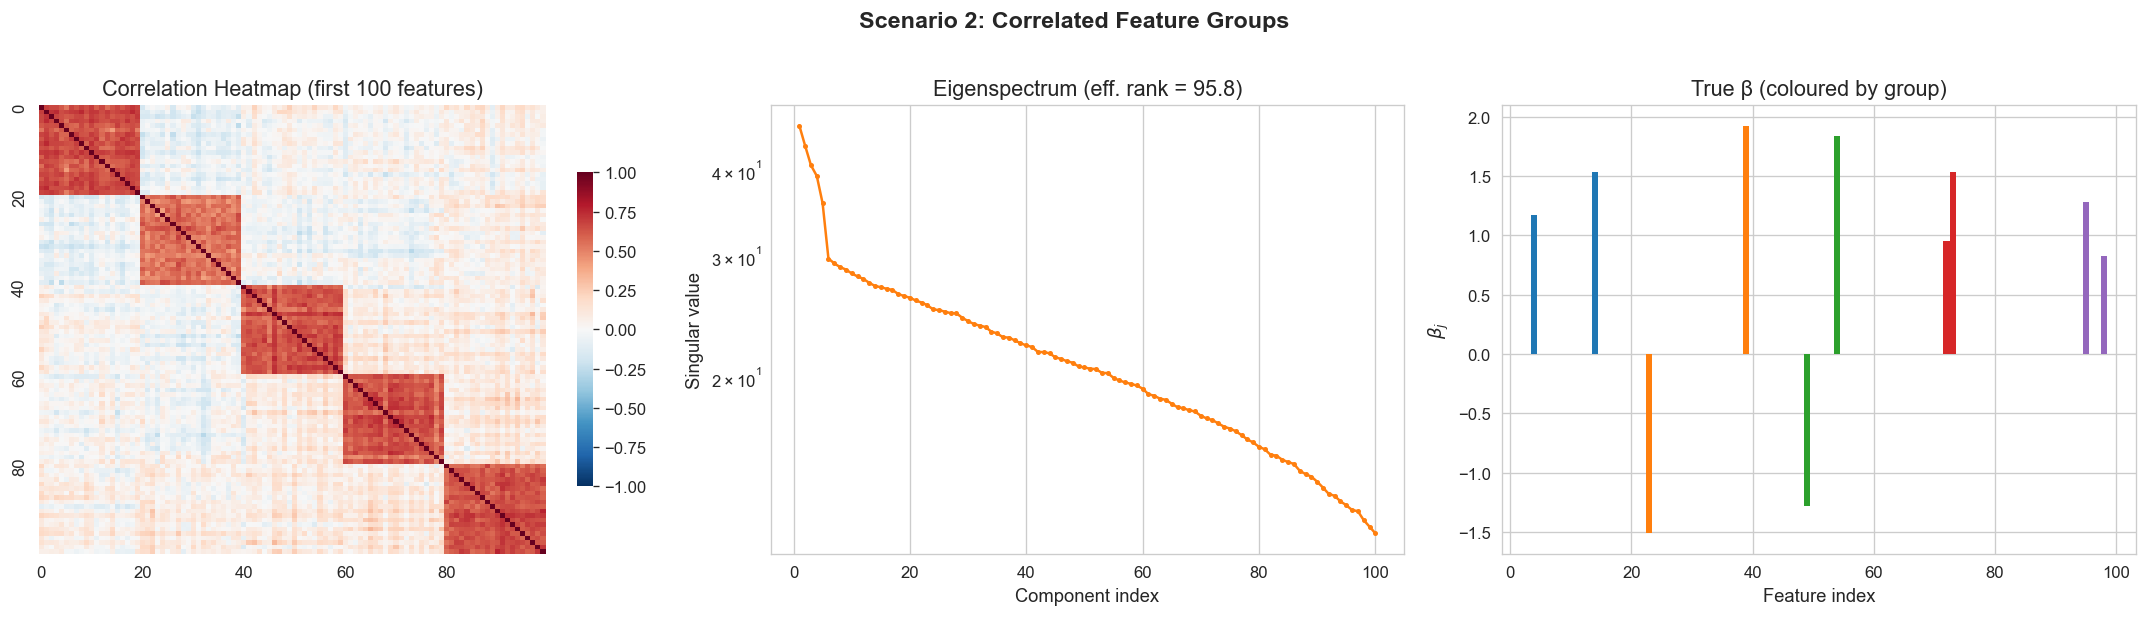

In [5]:
# ============================================================
# 3.2 — Correlated Feature Groups
# ============================================================

def generate_correlated_groups(n=100, p=500, n_groups=5, group_size=20,
                               correlation_strength=0.8, k_active_per_group=2,
                               signal_strength=1.0, noise_std=1.0, seed=42):
    """Latent-factor correlated groups with active betas within groups.
    
    X_j = ρ Z_g + √(1-ρ²) δ_j  for features in group g.
    Remaining features are iid N(0,1).
    """
    rng = np.random.default_rng(seed)
    rho = correlation_strength
    
    X = rng.standard_normal((n, p))  # start iid
    beta = np.zeros(p)
    group_labels = -np.ones(p, dtype=int)  # -1 = ungrouped
    
    for g in range(n_groups):
        start = g * group_size
        end = start + group_size
        if end > p:
            break
        
        # Latent factor for this group
        Z_g = rng.standard_normal(n)
        for j in range(start, end):
            delta_j = rng.standard_normal(n)
            X[:, j] = rho * Z_g + np.sqrt(1 - rho**2) * delta_j
            group_labels[j] = g
        
        # Active betas within this group
        active_in_group = rng.choice(range(start, end), k_active_per_group, replace=False)
        beta[active_in_group] = signal_strength * rng.choice([-1, 1], size=k_active_per_group) * rng.uniform(0.5, 2.0, size=k_active_per_group)
    
    y, epsilon = generate_response(X, beta, noise_std, rng)
    diag = compute_all_diagnostics(X, beta, noise_std, epsilon)
    
    params = dict(n=n, p=p, n_groups=n_groups, group_size=group_size,
                  correlation_strength=correlation_strength,
                  k_active_per_group=k_active_per_group,
                  signal_strength=signal_strength, noise_std=noise_std, seed=seed)
    
    return {'X': X, 'y': y, 'beta': beta, 'diag': diag, 'params': params,
            'group_labels': group_labels}


# ── Generate and visualise ────────────────────────────────────
res2 = generate_correlated_groups(n=100, p=500, seed=SEED)
print_diagnostics(res2['diag'], 'Scenario 2: Correlated Feature Groups')
ALL_SCENARIOS['Correlated Groups'] = res2

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) Correlation heatmap (first 100 features to show block structure)
ax = axes[0]
corr_sub = np.corrcoef(res2['X'][:, :100].T)
sns.heatmap(corr_sub, cmap='RdBu_r', vmin=-1, vmax=1, ax=ax,
            cbar_kws={'shrink': 0.7}, xticklabels=20, yticklabels=20)
ax.set_title('Correlation Heatmap (first 100 features)')

# (b) Eigenspectrum
ax = axes[1]
sv = res2['diag']['_sv']
ax.plot(np.arange(1, len(sv)+1), sv, 'o-', markersize=2, color='C1')
ax.set_xlabel('Component index')
ax.set_ylabel('Singular value')
ax.set_title(f'Eigenspectrum (eff. rank = {res2["diag"]["effective_rank"]:.1f})')
ax.set_yscale('log')

# (c) True β coloured by group
ax = axes[2]
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'grey']
for j in range(len(res2['beta'])):
    g = res2['group_labels'][j]
    c = colors[g] if g >= 0 else 'grey'
    if abs(res2['beta'][j]) > 1e-10:
        ax.bar(j, res2['beta'][j], color=c, width=1.0, edgecolor='none')
ax.set_xlabel('Feature index')
ax.set_ylabel(r'$\beta_j$')
ax.set_title('True β (coloured by group)')

plt.suptitle('Scenario 2: Correlated Feature Groups', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.3 — Dense Signal Regime

**DGP:** $\beta_j \neq 0$ for $\sim 90\%$ of features, with $\beta_j \sim \mathcal{N}(0, \sigma^2_{\text{signal}})$.

**Why it matters:**

- **Ridge** is theoretically optimal here (James–Stein shrinkage).
- **Lasso** over-shrinks many small-but-nonzero coefficients to zero → bias.
- **Horseshoe** may also overshrink: its spike-and-slab-like shape pushes small βⱼ toward zero.
- **Elastic Net** with small α (close to Ridge) approaches optimal behaviour.



  Scenario 3: Dense Signal
  n                        :          200
  p                        :          100
  p_over_n                 :       0.5000
  SNR                      :      10.1746
  n_nonzero                :           90
  n_zero                   :           10
  zero_frac                :       0.1000
  L1_norm                  :      26.2121
  L2_norm                  :       3.4309
  gini                     :       0.4611
  mean_abs_corr            :       0.0558
  max_abs_corr             :       0.2480
  condition_number         :       5.0500
  effective_rank           :      92.7300
  intrinsic_dim_90         :           67



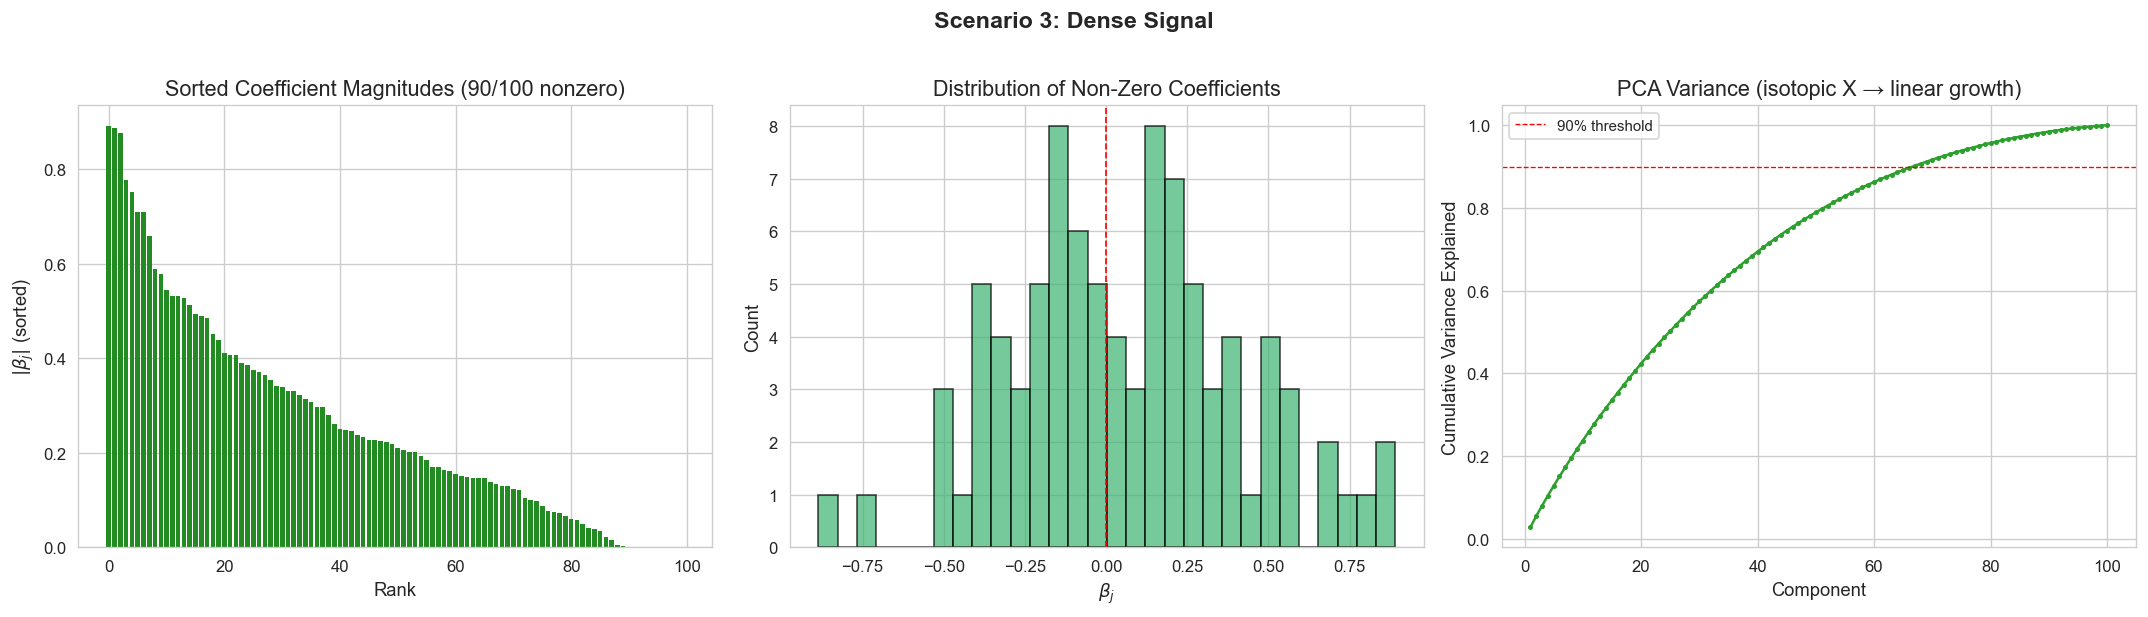

In [6]:
# ============================================================
# 3.3 — Dense Signal
# ============================================================

def generate_dense_signal(n=200, p=100, active_fraction=0.9,
                          signal_strength=0.3, noise_std=1.0, seed=42):
    """Dense regime: most predictors are non-zero.
    
    Favours Ridge over Lasso. Signal is spread across many features
    with small individual magnitudes.
    """
    rng = np.random.default_rng(seed)
    X = rng.standard_normal((n, p))
    
    beta = np.zeros(p)
    n_active = int(active_fraction * p)
    active_idx = rng.choice(p, n_active, replace=False)
    beta[active_idx] = rng.normal(0, signal_strength, size=n_active)
    
    y, epsilon = generate_response(X, beta, noise_std, rng)
    diag = compute_all_diagnostics(X, beta, noise_std, epsilon)
    
    params = dict(n=n, p=p, active_fraction=active_fraction,
                  signal_strength=signal_strength, noise_std=noise_std, seed=seed)
    return {'X': X, 'y': y, 'beta': beta, 'diag': diag, 'params': params}


# ── Generate and visualise ────────────────────────────────────
res3 = generate_dense_signal(seed=SEED)
print_diagnostics(res3['diag'], 'Scenario 3: Dense Signal')
ALL_SCENARIOS['Dense Signal'] = res3

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) Sorted |β|
ax = axes[0]
sorted_abs_beta = np.sort(np.abs(res3['beta']))[::-1]
ax.bar(range(len(sorted_abs_beta)), sorted_abs_beta, color='forestgreen', edgecolor='none')
ax.set_xlabel('Rank')
ax.set_ylabel(r'$|\beta_j|$ (sorted)')
ax.set_title(f'Sorted Coefficient Magnitudes ({res3["diag"]["n_nonzero"]}/{len(res3["beta"])} nonzero)')

# (b) Histogram of β magnitudes
ax = axes[1]
ax.hist(res3['beta'][res3['beta'] != 0], bins=30, color='mediumseagreen',
        edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', ls='--', lw=1)
ax.set_xlabel(r'$\beta_j$')
ax.set_ylabel('Count')
ax.set_title('Distribution of Non-Zero Coefficients')

# (c) PCA cumulative variance
ax = axes[2]
cum_var = res3['diag']['_cum_var']
ax.plot(np.arange(1, len(cum_var)+1), cum_var, 'o-', markersize=2, color='C2')
ax.axhline(0.9, color='red', ls='--', lw=0.8, label='90% threshold')
ax.set_xlabel('Component')
ax.set_ylabel('Cumulative Variance Explained')
ax.set_title('PCA Variance (isotopic X → linear growth)')
ax.legend()

plt.suptitle('Scenario 3: Dense Signal', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.4 — Weak Signal Regime (Low SNR)

**DGP:** $\beta_j = 0.05$ for active features, $\varepsilon \sim \mathcal{N}(0, 1)$ → target $\text{SNR} \ll 1$.

**Why it matters:**

- Signal buried in noise — all methods struggle.
- **Lasso** with CV λ tends to overshrink and miss weak signals entirely.
- **Horseshoe** adaptive heavy tails _can_ sometimes detect weak-but-real signals.
- **Ridge** preserves all signals but amplifies noise equally.
- This regime tests **false-positive control** more than signal recovery.



  Scenario 4: Weak Signal (Low SNR)
  n                        :          100
  p                        :          500
  p_over_n                 :       5.0000
  SNR                      :       0.0181
  n_nonzero                :           10
  n_zero                   :          490
  zero_frac                :       0.9800
  L1_norm                  :       0.5000
  L2_norm                  :       0.1581
  gini                     :       0.9800
  mean_abs_corr            :       0.0800
  max_abs_corr             :       0.3731
  condition_number         :       2.5300
  effective_rank           :      97.3400
  intrinsic_dim_90         :           79



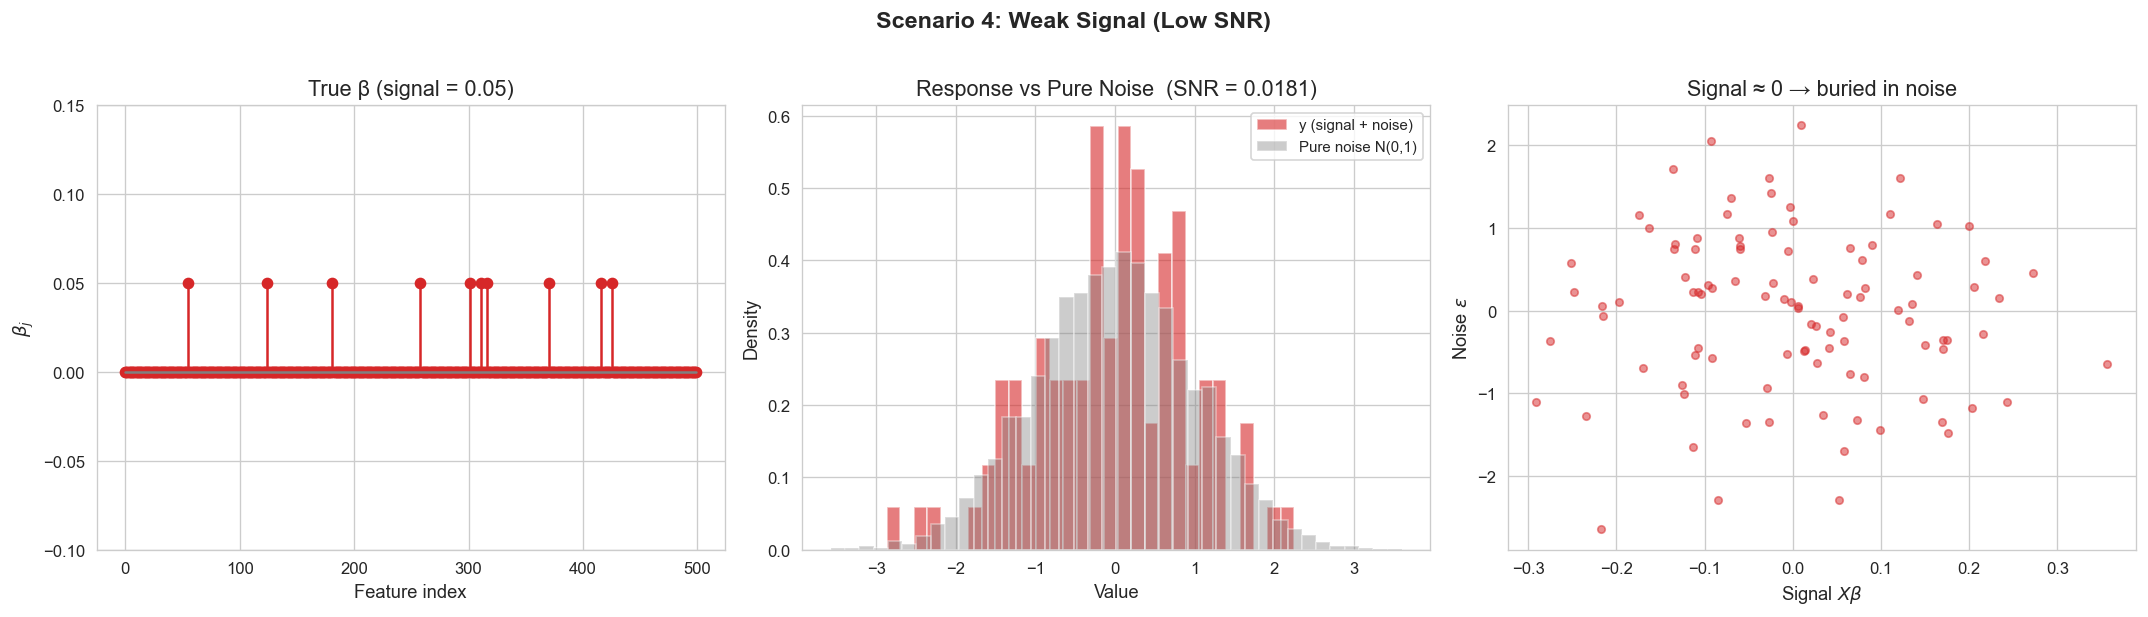

In [7]:
# ============================================================
# 3.4 — Weak Signal (Low SNR)
# ============================================================

def generate_weak_signal(n=100, p=500, k=10, signal_strength=0.05,
                         noise_std=1.0, seed=42):
    """Very low SNR: β_j ≈ small constant for active features.
    
    Tests whether methods can detect weak signals without excessive
    false discoveries.
    """
    rng = np.random.default_rng(seed)
    X = rng.standard_normal((n, p))
    
    beta = np.zeros(p)
    active_idx = rng.choice(p, k, replace=False)
    beta[active_idx] = signal_strength  # constant small value
    
    y, epsilon = generate_response(X, beta, noise_std, rng)
    diag = compute_all_diagnostics(X, beta, noise_std, epsilon)
    
    params = dict(n=n, p=p, k=k, signal_strength=signal_strength,
                  noise_std=noise_std, seed=seed)
    return {'X': X, 'y': y, 'beta': beta, 'diag': diag,
            'params': params, 'active_idx': active_idx}


# ── Generate and visualise ────────────────────────────────────
res4 = generate_weak_signal(seed=SEED)
print_diagnostics(res4['diag'], 'Scenario 4: Weak Signal (Low SNR)')
ALL_SCENARIOS['Weak Signal'] = res4

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) True β (nearly flat)
ax = axes[0]
ax.stem(np.arange(len(res4['beta'])), res4['beta'], linefmt='C3-',
        markerfmt='C3o', basefmt='grey')
ax.set_xlabel('Feature index')
ax.set_ylabel(r'$\beta_j$')
ax.set_title(f'True β (signal = {res4["params"]["signal_strength"]})')
ax.set_ylim(-0.1, 0.15)

# (b) y distribution overlaid with pure noise
ax = axes[1]
ax.hist(res4['y'], bins=30, alpha=0.6, color='C3', label='y (signal + noise)', density=True)
noise_only = np.random.default_rng(99).normal(0, res4['params']['noise_std'], 10000)
ax.hist(noise_only, bins=40, alpha=0.4, color='grey', label='Pure noise N(0,1)', density=True)
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.set_title(f'Response vs Pure Noise  (SNR = {res4["diag"]["SNR"]:.4f})')
ax.legend()

# (c) Signal vs noise scatter
ax = axes[2]
signal = res4['X'] @ res4['beta']
noise = res4['y'] - signal
ax.scatter(signal, noise, alpha=0.5, s=20, c='C3')
ax.set_xlabel(r'Signal $X\beta$')
ax.set_ylabel(r'Noise $\varepsilon$')
ax.set_title('Signal ≈ 0 → buried in noise')

plt.suptitle('Scenario 4: Weak Signal (Low SNR)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.5 — Ultra High-Dimensional Regime ($p \gg n$)

**DGP:** $n = 100$, $p = 5000$, sparse $\beta$. Design matrix $X$ is rank-deficient ($\text{rank} \leq n$).

**Why it matters:**

- OLS is not identifiable — $X^TX$ is singular.
- **Lasso** needs the restricted eigenvalue / compatibility condition to succeed.
- **Horseshoe** excels via global-local shrinkage: global $\tau$ adapts to sparsity level, local $\lambda_j$ lets true signals escape.
- **Ridge** shrinks everything uniformly — no selection, poor interpretability.
- This is the regime where **Bayesian shrinkage priors were specifically designed to work**.



  Scenario 5: Ultra High-Dimensional
  n                        :          100
  p                        :         5000
  p_over_n                 :      50.0000
  SNR                      :      24.3478
  n_nonzero                :           15
  n_zero                   :         4985
  zero_frac                :       0.9970
  L1_norm                  :      17.8758
  L2_norm                  :       5.0334
  gini                     :       0.9977
  mean_abs_corr            :       0.0808
  max_abs_corr             :       0.4147
  condition_number         :       1.3000
  effective_rank           :      99.7500
  intrinsic_dim_90         :           88



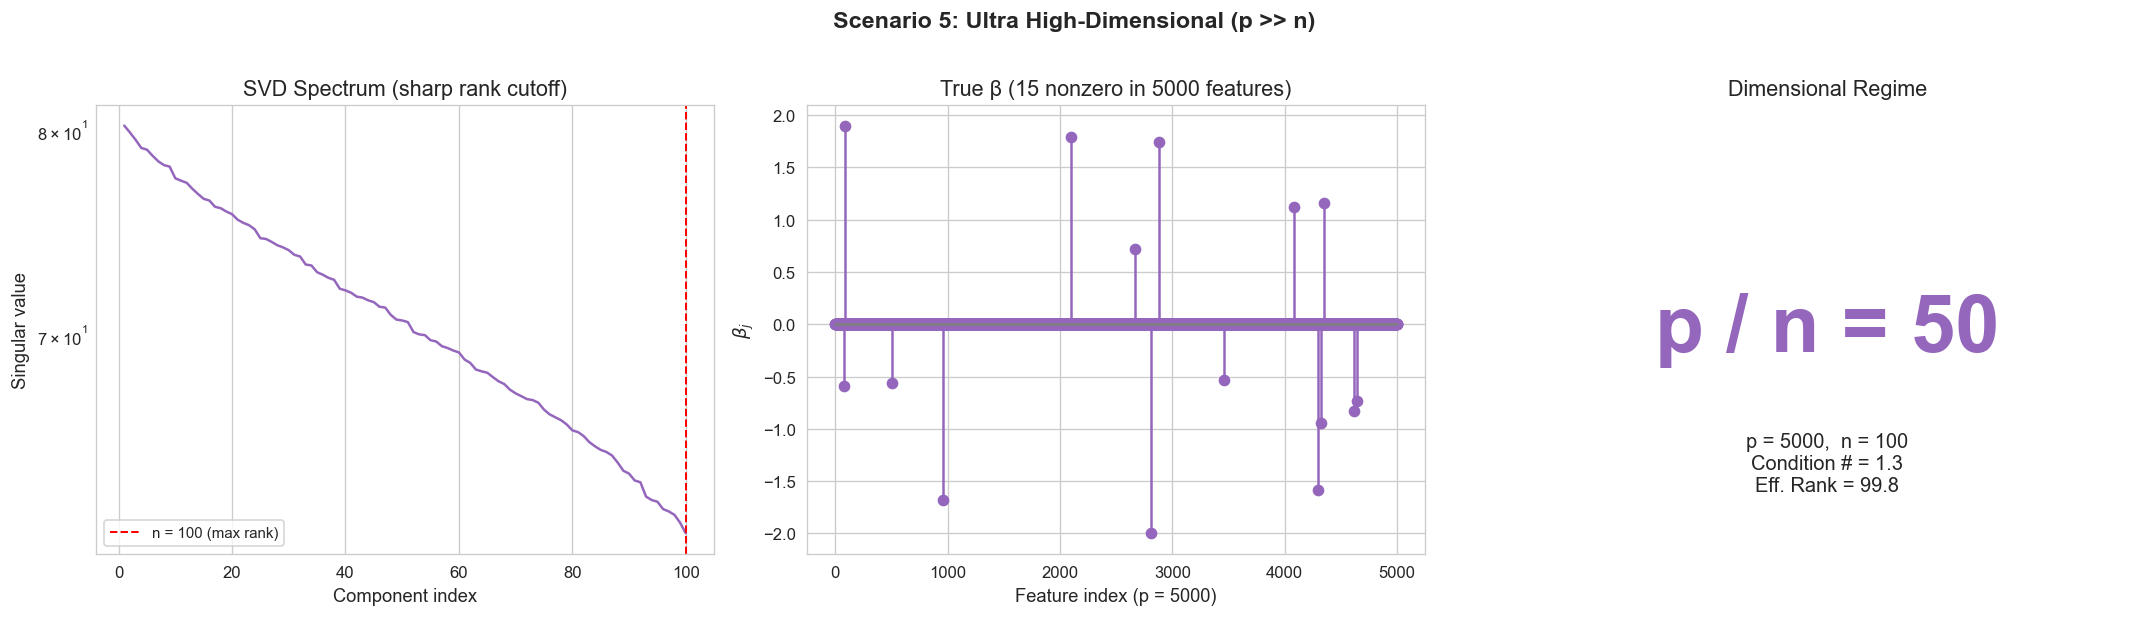

In [8]:
# ============================================================
# 3.5 — Ultra High-Dimensional (p >> n)
# ============================================================

def generate_ultra_high_dim(n=100, p=5000, k=15, signal_strength=1.0,
                            noise_std=1.0, seed=42):
    """p >> n regime: design matrix is rank-deficient.
    
    X^TX is singular → OLS impossible. Penalisation/shrinkage essential.
    Horseshoe's global-local structure shines here.
    """
    rng = np.random.default_rng(seed)
    X = rng.standard_normal((n, p))
    
    beta = np.zeros(p)
    active_idx = rng.choice(p, k, replace=False)
    beta[active_idx] = signal_strength * rng.choice([-1, 1], k) * rng.uniform(0.5, 2.0, k)
    
    y, epsilon = generate_response(X, beta, noise_std, rng)
    diag = compute_all_diagnostics(X, beta, noise_std, epsilon)
    
    params = dict(n=n, p=p, k=k, signal_strength=signal_strength,
                  noise_std=noise_std, seed=seed)
    return {'X': X, 'y': y, 'beta': beta, 'diag': diag,
            'params': params, 'active_idx': active_idx}


# ── Generate and visualise ────────────────────────────────────
res5 = generate_ultra_high_dim(seed=SEED)
print_diagnostics(res5['diag'], 'Scenario 5: Ultra High-Dimensional')
ALL_SCENARIOS['Ultra High-Dim'] = res5

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) Singular value spectrum — sharp cutoff at rank n
ax = axes[0]
sv = res5['diag']['_sv']
ax.plot(np.arange(1, len(sv)+1), sv, '-', color='C4', lw=1.5)
ax.axvline(res5['params']['n'], color='red', ls='--', lw=1.2,
           label=f'n = {res5["params"]["n"]} (max rank)')
ax.set_xlabel('Component index')
ax.set_ylabel('Singular value')
ax.set_title('SVD Spectrum (sharp rank cutoff)')
ax.set_yscale('log')
ax.legend()

# (b) True β stem in p=5000 space
ax = axes[1]
active = res5['active_idx']
ax.stem(np.arange(len(res5['beta'])), res5['beta'], linefmt='C4-',
        markerfmt='C4o', basefmt='grey')
ax.set_xlabel('Feature index (p = 5000)')
ax.set_ylabel(r'$\beta_j$')
ax.set_title(f'True β ({res5["diag"]["n_nonzero"]} nonzero in {res5["params"]["p"]} features)')

# (c) p/n ratio display
ax = axes[2]
pn = res5['params']['p'] / res5['params']['n']
ax.text(0.5, 0.5, f'p / n = {pn:.0f}', transform=ax.transAxes,
        fontsize=48, ha='center', va='center', fontweight='bold', color='C4')
ax.text(0.5, 0.2, f'p = {res5["params"]["p"]},  n = {res5["params"]["n"]}\n'
        f'Condition # = {res5["diag"]["condition_number"]:.1f}\n'
        f'Eff. Rank = {res5["diag"]["effective_rank"]:.1f}',
        transform=ax.transAxes, fontsize=12, ha='center', va='center')
ax.set_xlim(0, 1); ax.set_ylim(0, 1)
ax.axis('off')
ax.set_title('Dimensional Regime')

plt.suptitle('Scenario 5: Ultra High-Dimensional (p >> n)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.6 — Block Correlation Structure

**DGP:** Block-diagonal covariance $\Sigma$ with intra-block correlation $\rho = 0.9$, inter-block $= 0$. $X \sim \mathcal{N}(0, \Sigma)$ via Cholesky.

**Why it matters:** Common in genomics (gene pathways) and finance (sector correlations).

- **Lasso** irrepresentable condition violated _within_ blocks → inconsistent selection.
- **Group Lasso** designed for this but standard Lasso is not.
- **Horseshoe** adapts via local parameters but doesn't know group structure.
- **Ridge** prediction stable, but non-sparse.



  Scenario 6: Block Correlation
  n                        :          200
  p                        :          200
  p_over_n                 :       1.0000
  SNR                      :       8.6532
  n_nonzero                :           12
  n_zero                   :          188
  zero_frac                :       0.9400
  L1_norm                  :      13.3433
  L2_norm                  :       4.3140
  gini                     :       0.9561
  mean_abs_corr            :       0.2488
  max_abs_corr             :       0.9281
  condition_number         :    3051.4400
  effective_rank           :      88.7000
  intrinsic_dim_90         :            7



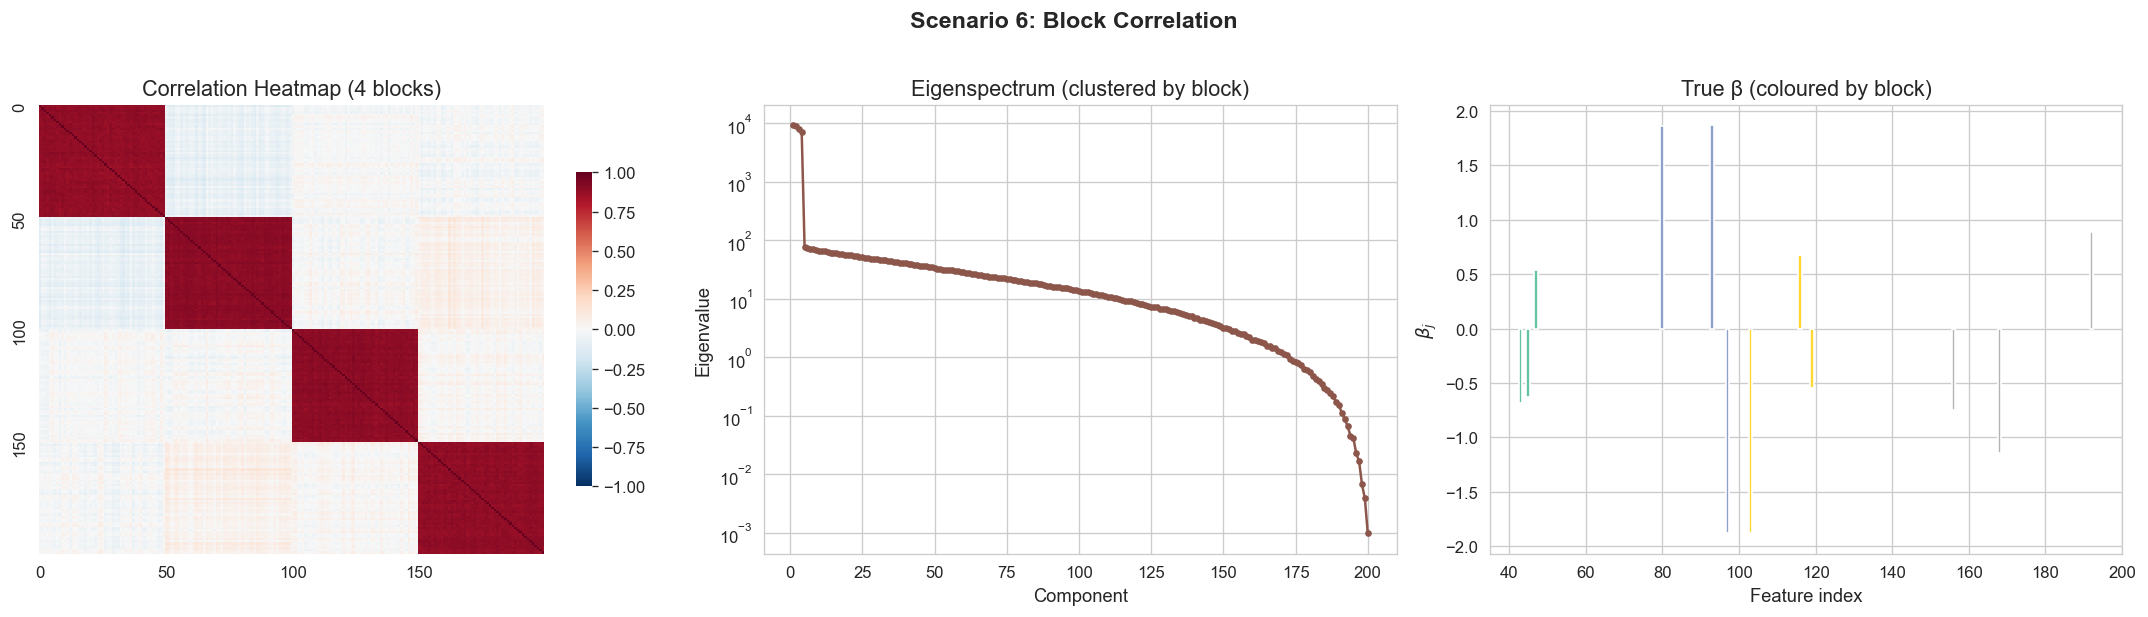

In [9]:
# ============================================================
# 3.6 — Block Correlation Structure
# ============================================================

def generate_block_correlation(n=200, p=200, n_blocks=4, block_size=50,
                               intra_corr=0.9, inter_corr=0.0,
                               k_per_block=3, signal_strength=1.0,
                               noise_std=1.0, seed=42):
    """Block-diagonal Σ with high intra-block correlation.
    
    Generates X ~ N(0, Σ) via Cholesky decomposition.
    Active betas placed in each block.
    """
    rng = np.random.default_rng(seed)
    
    # Build block-diagonal covariance
    Sigma = np.eye(p) * (1 - inter_corr) + inter_corr
    for b in range(n_blocks):
        start = b * block_size
        end = min(start + block_size, p)
        Sigma[start:end, start:end] = (1 - intra_corr) * np.eye(end - start) + intra_corr
    
    # Cholesky decomposition for sampling
    L = np.linalg.cholesky(Sigma)
    Z = rng.standard_normal((n, p))
    X = Z @ L.T
    
    # Active betas in each block
    beta = np.zeros(p)
    for b in range(n_blocks):
        start = b * block_size
        end = min(start + block_size, p)
        active_in_block = rng.choice(range(start, end),
                                      min(k_per_block, end - start), replace=False)
        beta[active_in_block] = (signal_strength *
                                  rng.choice([-1, 1], len(active_in_block)) *
                                  rng.uniform(0.5, 2.0, len(active_in_block)))
    
    y, epsilon = generate_response(X, beta, noise_std, rng)
    diag = compute_all_diagnostics(X, beta, noise_std, epsilon)
    
    params = dict(n=n, p=p, n_blocks=n_blocks, block_size=block_size,
                  intra_corr=intra_corr, inter_corr=inter_corr,
                  k_per_block=k_per_block, signal_strength=signal_strength,
                  noise_std=noise_std, seed=seed)
    return {'X': X, 'y': y, 'beta': beta, 'diag': diag,
            'params': params, 'Sigma': Sigma}


# ── Generate and visualise ────────────────────────────────────
res6 = generate_block_correlation(seed=SEED)
print_diagnostics(res6['diag'], 'Scenario 6: Block Correlation')
ALL_SCENARIOS['Block Correlation'] = res6

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) Full correlation heatmap
ax = axes[0]
corr_full = np.corrcoef(res6['X'].T)
sns.heatmap(corr_full, cmap='RdBu_r', vmin=-1, vmax=1, ax=ax,
            cbar_kws={'shrink': 0.7}, xticklabels=50, yticklabels=50)
ax.set_title(f'Correlation Heatmap ({res6["params"]["n_blocks"]} blocks)')

# (b) Eigenspectrum showing clusters
ax = axes[1]
sv = res6['diag']['_sv']
ax.plot(np.arange(1, len(sv)+1), sv**2, 'o-', markersize=3, color='C5')
ax.set_xlabel('Component')
ax.set_ylabel('Eigenvalue')
ax.set_title('Eigenspectrum (clustered by block)')
ax.set_yscale('log')

# (c) True β
ax = axes[2]
colors_6 = plt.cm.Set2(np.linspace(0, 1, res6['params']['n_blocks']))
for j in range(len(res6['beta'])):
    block_id = j // res6['params']['block_size']
    if block_id < res6['params']['n_blocks'] and abs(res6['beta'][j]) > 1e-10:
        ax.bar(j, res6['beta'][j], color=colors_6[block_id], width=1.0)
ax.set_xlabel('Feature index')
ax.set_ylabel(r'$\beta_j$')
ax.set_title('True β (coloured by block)')

plt.suptitle('Scenario 6: Block Correlation', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.7 — Heavy-Tailed Noise

**DGP:** $\varepsilon \sim t_3$ (Student-t, 3 df) or contaminated Gaussian $0.9\,\mathcal{N}(0,1) + 0.1\,\mathcal{N}(0,25)$.

**Why it matters:**

- Squared-loss methods (Lasso, Ridge) are sensitive to outliers.
- Bayesian methods with Gaussian likelihood are also affected.
- Tests **robustness** of each approach — LAD-Lasso or Huber loss variants would be more appropriate here.
- Horseshoe posterior can be distorted by outliers in $y$.



  Scenario 7: Heavy-Tailed Noise (t₃)
  n                        :          200
  p                        :          100
  p_over_n                 :       0.5000
  SNR                      :      21.6332
  n_nonzero                :           10
  n_zero                   :           90
  zero_frac                :       0.9000
  L1_norm                  :      11.1161
  L2_norm                  :       3.7482
  gini                     :       0.9206
  mean_abs_corr            :       0.0558
  max_abs_corr             :       0.2480
  condition_number         :       5.0500
  effective_rank           :      92.7300
  intrinsic_dim_90         :           67
  noise_kurtosis           :       1.2205



C:\Users\karth\AppData\Local\Temp\ipykernel_18144\2002850241.py:84: UserWarning: Glyph 8323 (\N{SUBSCRIPT THREE}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\karth\miniconda3\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8323 (\N{SUBSCRIPT THREE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


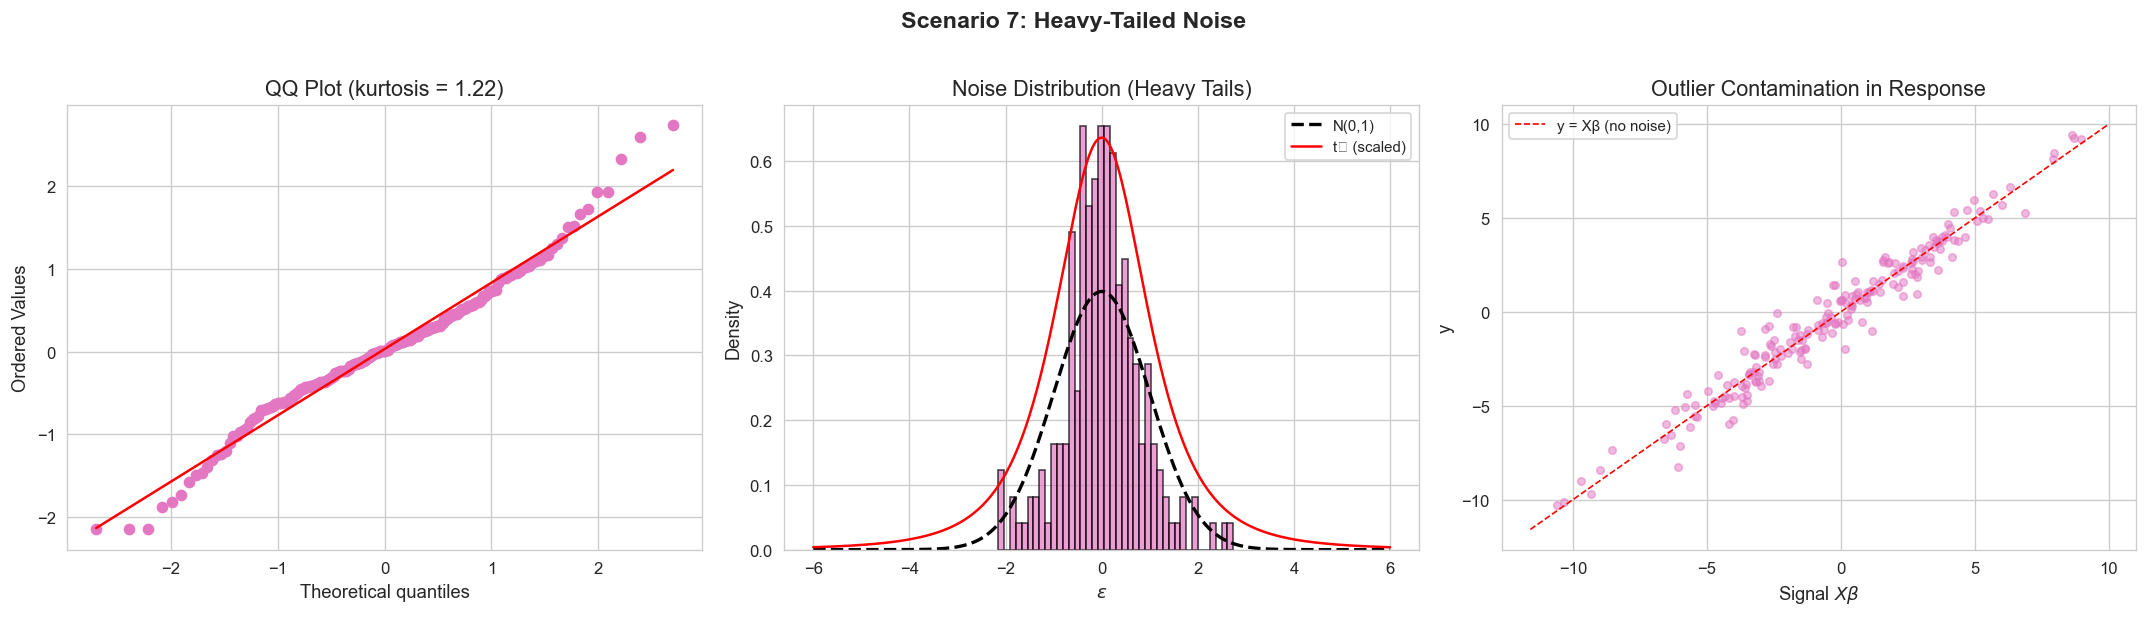

In [10]:
# ============================================================
# 3.7 — Heavy-Tailed Noise
# ============================================================

def generate_heavy_tailed_noise(n=200, p=100, k=10, signal_strength=1.0,
                                noise_type='student_t', df=3, seed=42):
    """Heavy-tailed noise: Student-t or contaminated Gaussian.
    
    Noise is scaled to have unit variance for fair SNR comparison.
    """
    rng = np.random.default_rng(seed)
    X = rng.standard_normal((n, p))
    
    beta = np.zeros(p)
    active_idx = rng.choice(p, k, replace=False)
    beta[active_idx] = signal_strength * rng.choice([-1, 1], k) * rng.uniform(0.5, 2.0, k)
    
    # Generate heavy-tailed noise
    if noise_type == 'student_t':
        raw_noise = rng.standard_t(df, size=n)
        # Var of t_df = df/(df-2) for df > 2
        if df > 2:
            raw_noise /= np.sqrt(df / (df - 2))
    elif noise_type == 'mixture':
        # 0.9 N(0,1) + 0.1 N(0,25) → Var = 0.9*1 + 0.1*25 = 3.4
        mask = rng.random(n) < 0.1
        raw_noise = rng.standard_normal(n)
        raw_noise[mask] *= 5.0  # σ=5 → σ²=25
        mixture_var = 0.9 * 1 + 0.1 * 25
        raw_noise /= np.sqrt(mixture_var)
    else:
        raw_noise = rng.standard_normal(n)
    
    epsilon = raw_noise
    y = X @ beta + epsilon
    noise_std_actual = np.std(epsilon)
    
    diag = compute_all_diagnostics(X, beta, noise_std_actual, epsilon)
    diag['noise_kurtosis'] = round(float(stats.kurtosis(epsilon, fisher=True)), 4)
    
    params = dict(n=n, p=p, k=k, signal_strength=signal_strength,
                  noise_type=noise_type, df=df, seed=seed)
    return {'X': X, 'y': y, 'beta': beta, 'diag': diag,
            'params': params, 'epsilon': epsilon}


# ── Generate and visualise ────────────────────────────────────
res7 = generate_heavy_tailed_noise(noise_type='student_t', df=3, seed=SEED)
print_diagnostics(res7['diag'], 'Scenario 7: Heavy-Tailed Noise (t₃)')
ALL_SCENARIOS['Heavy-Tailed Noise'] = res7

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) QQ plot vs normal
ax = axes[0]
stats.probplot(res7['epsilon'], dist='norm', plot=ax)
ax.set_title(f'QQ Plot (kurtosis = {res7["diag"]["noise_kurtosis"]:.2f})')
ax.get_lines()[0].set_color('C6')

# (b) Noise histogram with normal overlay
ax = axes[1]
ax.hist(res7['epsilon'], bins=40, density=True, alpha=0.7, color='C6', edgecolor='black')
x_range = np.linspace(-6, 6, 300)
ax.plot(x_range, stats.norm.pdf(x_range), 'k--', lw=2, label='N(0,1)')
ax.plot(x_range, stats.t.pdf(x_range, df=3) * np.sqrt(3), 'r-', lw=1.5,
        label='t₃ (scaled)')
ax.set_xlabel(r'$\varepsilon$')
ax.set_ylabel('Density')
ax.set_title('Noise Distribution (Heavy Tails)')
ax.legend()

# (c) y vs Xβ scatter showing outlier contamination
ax = axes[2]
signal = res7['X'] @ res7['beta']
ax.scatter(signal, res7['y'], alpha=0.5, s=20, c='C6')
xlim = ax.get_xlim()
ax.plot(xlim, xlim, 'r--', lw=1, label='y = Xβ (no noise)')
ax.set_xlabel(r'Signal $X\beta$')
ax.set_ylabel('y')
ax.set_title('Outlier Contamination in Response')
ax.legend()

plt.suptitle('Scenario 7: Heavy-Tailed Noise', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.8 — Heteroskedastic Noise

**DGP:** $\varepsilon_i \sim \mathcal{N}(0, \sigma_i^2)$ where $\sigma_i^2 = 0.1 + 2|X_i \beta_{\text{active}}|$ (variance grows with signal magnitude).

**Why it matters:**

- Standard Lasso/Ridge use unweighted least squares → inefficient under heteroskedasticity.
- Weighted variants exist but require variance estimation.
- Bayesian hierarchical models can accommodate heteroskedasticity.
- Horseshoe is typically applied assuming homoskedastic noise.



  Scenario 8: Heteroskedastic Noise
  n                        :          200
  p                        :          100
  p_over_n                 :       0.5000
  SNR                      :       2.2301
  n_nonzero                :           10
  n_zero                   :           90
  zero_frac                :       0.9000
  L1_norm                  :      11.1161
  L2_norm                  :       3.7482
  gini                     :       0.9206
  mean_abs_corr            :       0.0558
  max_abs_corr             :       0.2480
  condition_number         :       5.0500
  effective_rank           :      92.7300
  intrinsic_dim_90         :           67
  noise_var_min            :       0.1402
  noise_var_max            :      21.3272
  noise_var_ratio          :     152.0800



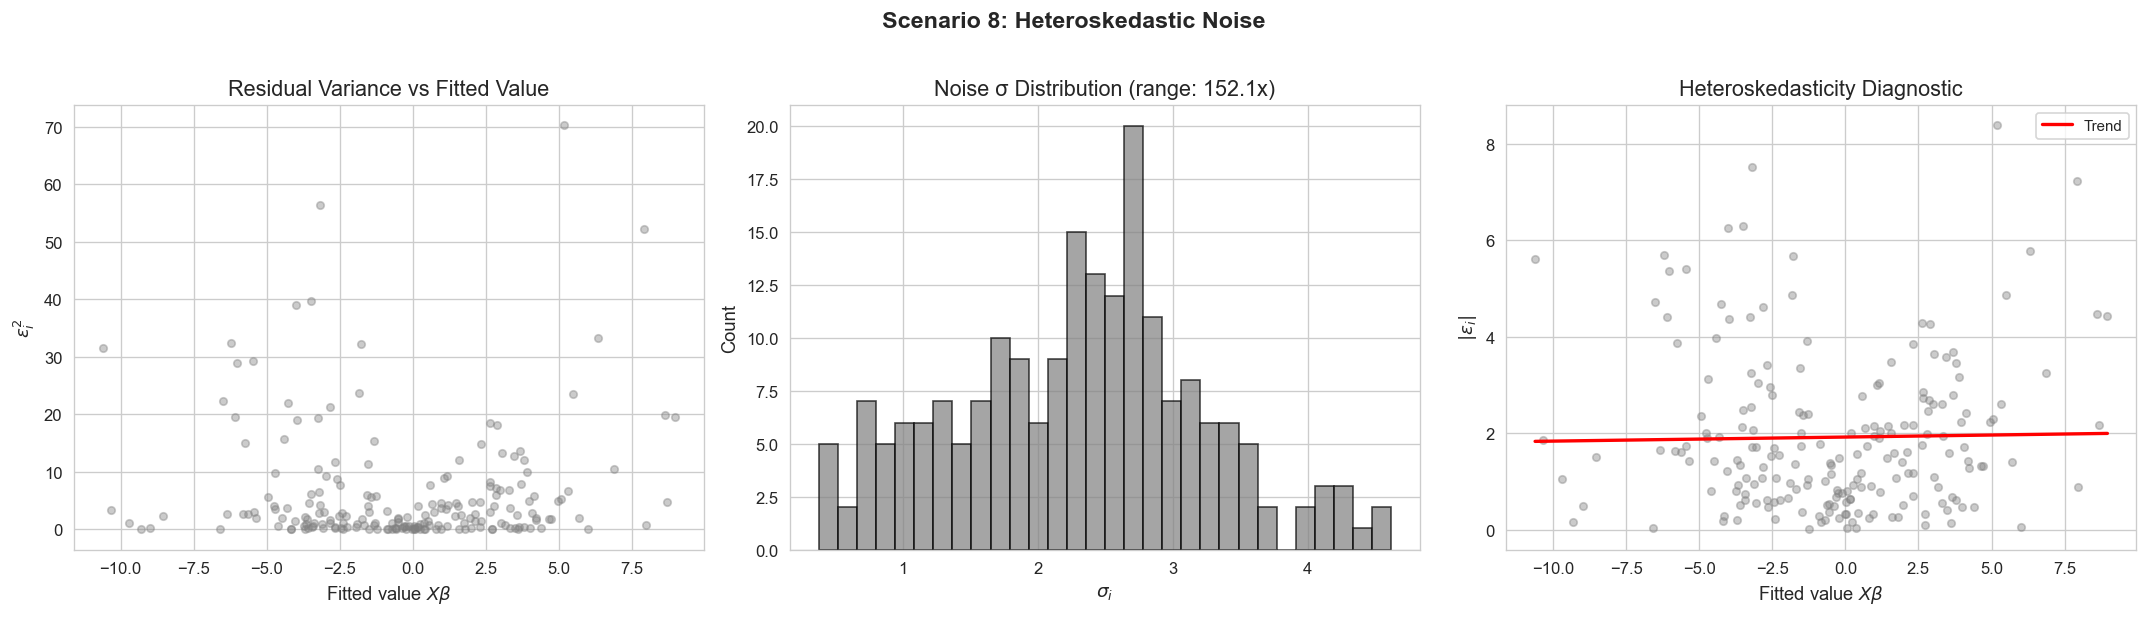

In [11]:
# ============================================================
# 3.8 — Heteroskedastic Noise
# ============================================================

def generate_heteroskedastic(n=200, p=100, k=10, signal_strength=1.0,
                             hetero_type='linear', seed=42):
    """Noise variance depends on signal magnitude.
    
    linear:      σ²_i = 0.1 + 2 |X_i β_active|
    exponential: σ²_i = exp(0.5 X_i1)  (first feature)
    """
    rng = np.random.default_rng(seed)
    X = rng.standard_normal((n, p))
    
    beta = np.zeros(p)
    active_idx = rng.choice(p, k, replace=False)
    beta[active_idx] = signal_strength * rng.choice([-1, 1], k) * rng.uniform(0.5, 2.0, k)
    
    # Compute heteroskedastic variance
    if hetero_type == 'linear':
        signal_mag = np.abs(X @ beta)
        sigma_sq = 0.1 + 2.0 * signal_mag
    elif hetero_type == 'exponential':
        sigma_sq = np.exp(0.5 * X[:, 0])
    else:
        sigma_sq = np.ones(n)
    
    sigma = np.sqrt(sigma_sq)
    epsilon = rng.standard_normal(n) * sigma
    y = X @ beta + epsilon
    
    noise_std_eff = np.std(epsilon)
    diag = compute_all_diagnostics(X, beta, noise_std_eff, epsilon)
    diag['noise_var_min'] = round(float(np.min(sigma_sq)), 4)
    diag['noise_var_max'] = round(float(np.max(sigma_sq)), 4)
    diag['noise_var_ratio'] = round(float(np.max(sigma_sq) / np.min(sigma_sq)), 2)
    
    params = dict(n=n, p=p, k=k, signal_strength=signal_strength,
                  hetero_type=hetero_type, seed=seed)
    return {'X': X, 'y': y, 'beta': beta, 'diag': diag,
            'params': params, 'sigma': sigma, 'epsilon': epsilon}


# ── Generate and visualise ────────────────────────────────────
res8 = generate_heteroskedastic(seed=SEED)
print_diagnostics(res8['diag'], 'Scenario 8: Heteroskedastic Noise')
ALL_SCENARIOS['Heteroskedastic'] = res8

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) Residual variance vs fitted
ax = axes[0]
fitted = res8['X'] @ res8['beta']
ax.scatter(fitted, res8['epsilon']**2, alpha=0.4, s=20, c='C7')
ax.set_xlabel(r'Fitted value $X\beta$')
ax.set_ylabel(r'$\varepsilon_i^2$')
ax.set_title('Residual Variance vs Fitted Value')

# (b) Noise σ distribution
ax = axes[1]
ax.hist(res8['sigma'], bins=30, color='C7', edgecolor='black', alpha=0.7)
ax.set_xlabel(r'$\sigma_i$')
ax.set_ylabel('Count')
ax.set_title(f'Noise σ Distribution (range: {res8["diag"]["noise_var_ratio"]:.1f}x)')

# (c) Breusch-Pagan style: |residual| vs fitted
ax = axes[2]
ax.scatter(fitted, np.abs(res8['epsilon']), alpha=0.4, s=20, c='C7')
z = np.polyfit(fitted, np.abs(res8['epsilon']), 1)
x_fit = np.linspace(fitted.min(), fitted.max(), 100)
ax.plot(x_fit, np.polyval(z, x_fit), 'r-', lw=2, label='Trend')
ax.set_xlabel(r'Fitted value $X\beta$')
ax.set_ylabel(r'$|\varepsilon_i|$')
ax.set_title('Heteroskedasticity Diagnostic')
ax.legend()

plt.suptitle('Scenario 8: Heteroskedastic Noise', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.9 — Non-Gaussian Feature Distributions

**DGP:** Features drawn from log-normal, mixture Gaussian, or uniform distributions, then standardised.

**Why it matters:**

- Many Lasso theoretical guarantees assume sub-Gaussian features.
- Log-normal features create right-skewed distributions → leverage points.
- Mixture Gaussians create bimodal feature distributions (e.g., gene on/off states).
- Horseshoe and Bayesian methods assume nothing specific about $X$ but posterior computation may be affected.



  Scenario 9: Non-Gaussian X (lognormal)
  n                        :          200
  p                        :          100
  p_over_n                 :       0.5000
  SNR                      :      14.5220
  n_nonzero                :           10
  n_zero                   :           90
  zero_frac                :       0.9000
  L1_norm                  :      11.1161
  L2_norm                  :       3.7482
  gini                     :       0.9206
  mean_abs_corr            :       0.0528
  max_abs_corr             :       0.3467
  condition_number         :       5.1900
  effective_rank           :      93.2000
  intrinsic_dim_90         :           68
  feature_skewness         :       3.5856
  feature_kurtosis         :      19.6686



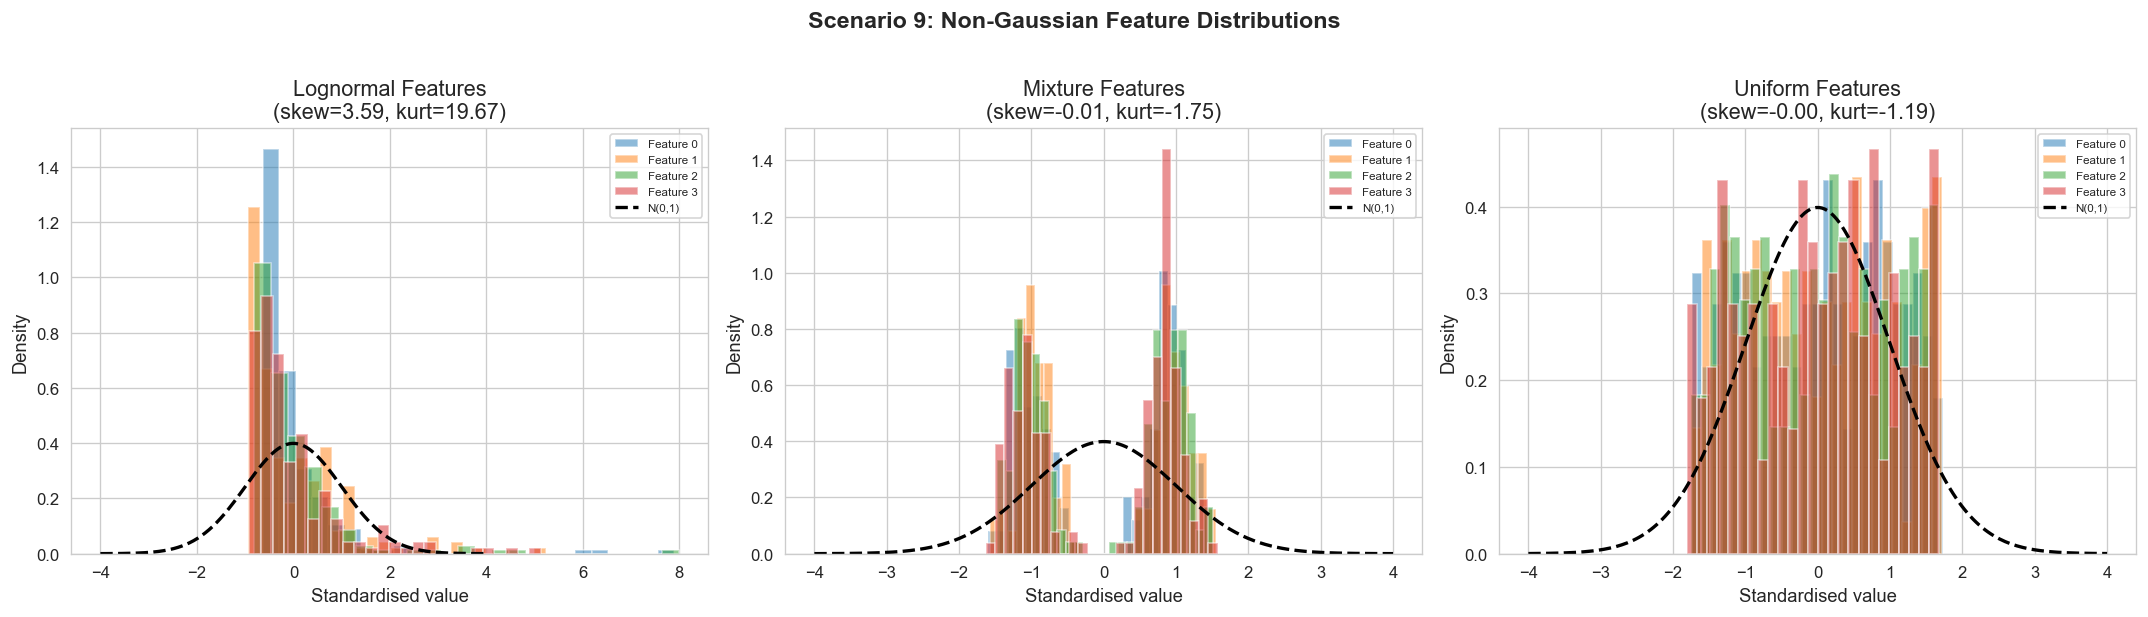

In [12]:
# ============================================================
# 3.9 — Non-Gaussian Feature Distributions
# ============================================================

def generate_nongaussian_features(n=200, p=100, k=10, feature_type='lognormal',
                                   signal_strength=1.0, noise_std=1.0, seed=42):
    """Features from non-Gaussian distributions, standardised to zero mean, unit var.
    
    Types: 'lognormal', 'mixture', 'uniform'
    """
    rng = np.random.default_rng(seed)
    
    if feature_type == 'lognormal':
        # Log-normal: X_j = exp(Z_j), Z_j ~ N(0,1)
        Z = rng.standard_normal((n, p))
        X_raw = np.exp(Z)
    elif feature_type == 'mixture':
        # 0.5 N(-2, 0.5²) + 0.5 N(2, 0.5²)
        mask = rng.random((n, p)) < 0.5
        X_raw = np.where(mask,
                         rng.normal(-2, 0.5, (n, p)),
                         rng.normal(2, 0.5, (n, p)))
    elif feature_type == 'uniform':
        # Uniform(-√3, √3) has variance = 1
        X_raw = rng.uniform(-np.sqrt(3), np.sqrt(3), (n, p))
    else:
        X_raw = rng.standard_normal((n, p))
    
    # Standardise: zero mean, unit variance per feature
    X = (X_raw - X_raw.mean(axis=0)) / (X_raw.std(axis=0) + 1e-12)
    
    beta = np.zeros(p)
    active_idx = rng.choice(p, k, replace=False)
    beta[active_idx] = signal_strength * rng.choice([-1, 1], k) * rng.uniform(0.5, 2.0, k)
    
    y, epsilon = generate_response(X, beta, noise_std, rng)
    diag = compute_all_diagnostics(X, beta, noise_std, epsilon)
    
    # Feature-level statistics
    diag['feature_skewness'] = round(float(np.mean(stats.skew(X, axis=0))), 4)
    diag['feature_kurtosis'] = round(float(np.mean(stats.kurtosis(X, axis=0, fisher=True))), 4)
    
    params = dict(n=n, p=p, k=k, feature_type=feature_type,
                  signal_strength=signal_strength, noise_std=noise_std, seed=seed)
    return {'X': X, 'y': y, 'beta': beta, 'diag': diag, 'params': params}


# ── Generate all three types and visualise ────────────────────
feature_types = ['lognormal', 'mixture', 'uniform']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, ft in enumerate(feature_types):
    res = generate_nongaussian_features(feature_type=ft, seed=SEED)
    if i == 0:
        ALL_SCENARIOS['Non-Gaussian X'] = res  # store lognormal as representative
        print_diagnostics(res['diag'], f'Scenario 9: Non-Gaussian X ({ft})')
    
    ax = axes[i]
    # Plot histogram of 4 representative features
    for j in range(4):
        ax.hist(res['X'][:, j], bins=25, alpha=0.5, density=True,
                label=f'Feature {j}')
    # Normal overlay
    x_range = np.linspace(-4, 4, 200)
    ax.plot(x_range, stats.norm.pdf(x_range), 'k--', lw=2, label='N(0,1)')
    ax.set_xlabel('Standardised value')
    ax.set_ylabel('Density')
    ax.set_title(f'{ft.title()} Features\n'
                 f'(skew={res["diag"]["feature_skewness"]:.2f}, '
                 f'kurt={res["diag"]["feature_kurtosis"]:.2f})')
    ax.legend(fontsize=7)

plt.suptitle('Scenario 9: Non-Gaussian Feature Distributions', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.10 — Structured (Group / Hierarchical) Sparsity

**DGP:** $p$ features divided into groups. Only a few groups are active, and within active groups only a fraction of features are nonzero. Optionally adds hierarchical structure (main effects + interactions).

**Why it matters:**

- Standard Lasso ignores group structure → may select features from inactive groups.
- **Group Lasso** enforces groups in/out but can't do within-group selection.
- **Sparse Group Lasso** combines both levels.
- **Horseshoe** treats each coefficient independently — doesn't encode group structure natively, but hierarchical Bayesian models can.
- This tests whether shrinkage methods can capture **structured** signal patterns without explicit group knowledge.



  Scenario 10: Structured Sparsity
  n                        :          200
  p                        :          300
  p_over_n                 :       1.5000
  SNR                      :      61.6566
  n_nonzero                :           67
  n_zero                   :          233
  zero_frac                :       0.7767
  L1_norm                  :      57.1975
  L2_norm                  :       8.1821
  gini                     :       0.8527
  mean_abs_corr            :       0.0560
  max_abs_corr             :       0.3060
  condition_number         :       9.1600
  effective_rank           :     179.2200
  intrinsic_dim_90         :          122
  n_active_groups          :            3
  n_total_groups           :           10



C:\Users\karth\AppData\Local\Temp\ipykernel_18144\1282209679.py:114: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True,


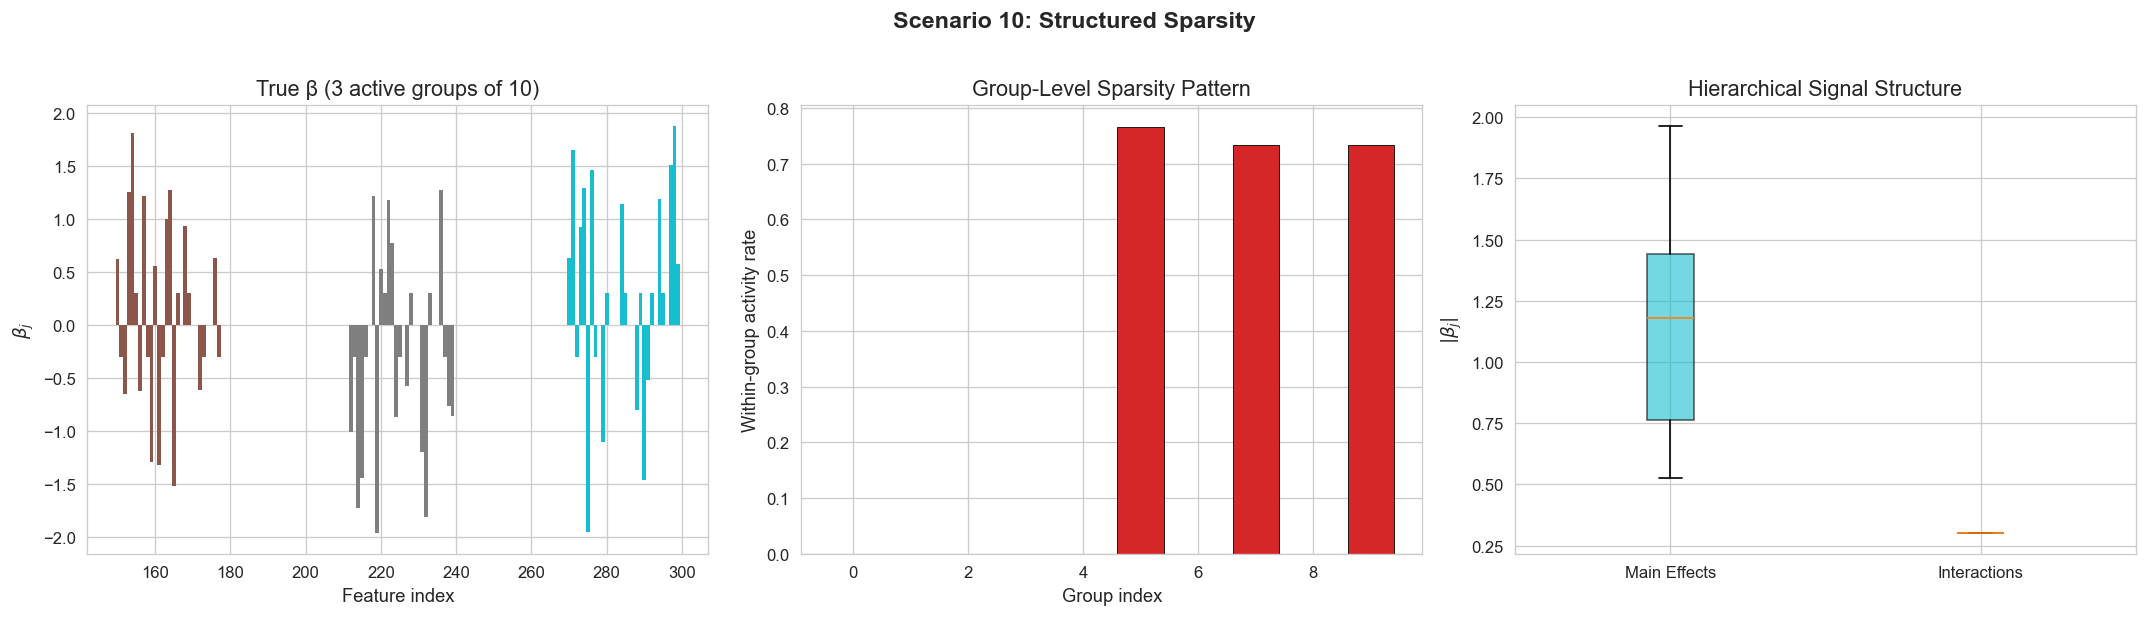

In [13]:
# ============================================================
# 3.10 — Structured (Group / Hierarchical) Sparsity
# ============================================================

def generate_structured_sparsity(n=200, p=300, n_groups=10, group_size=30,
                                  active_groups=3, sparsity_within_group=0.5,
                                  signal_strength=1.0, noise_std=1.0,
                                  hierarchy=True, seed=42):
    """Group sparsity + optional hierarchical structure.
    
    - Selects `active_groups` groups.
    - Within active groups, `sparsity_within_group` fraction of betas are nonzero.
    - If hierarchy=True, adds interaction terms that are only active when
      their parent main effect is active.
    """
    rng = np.random.default_rng(seed)
    X = rng.standard_normal((n, p))
    
    beta = np.zeros(p)
    group_labels = np.repeat(np.arange(n_groups), group_size)[:p]
    
    # Select active groups
    active_group_ids = rng.choice(n_groups, active_groups, replace=False)
    
    for g in active_group_ids:
        mask = group_labels == g
        group_indices = np.where(mask)[0]
        n_active_in_group = max(1, int(sparsity_within_group * len(group_indices)))
        active_in_group = rng.choice(group_indices, n_active_in_group, replace=False)
        
        # Main effects
        beta[active_in_group] = (signal_strength *
                                  rng.choice([-1, 1], len(active_in_group)) *
                                  rng.uniform(0.5, 2.0, len(active_in_group)))
        
        if hierarchy:
            # "Interaction" effects: only active if parent main effect is active
            # Use adjacent features as interaction proxies
            for idx in active_in_group:
                # Make adjacent feature a weak interaction if it exists and isn't already active
                neighbor = idx + 1 if idx + 1 < p else idx - 1
                if group_labels[neighbor] == g and abs(beta[neighbor]) < 1e-10:
                    beta[neighbor] = 0.3 * signal_strength * rng.choice([-1, 1])
    
    y, epsilon = generate_response(X, beta, noise_std, rng)
    diag = compute_all_diagnostics(X, beta, noise_std, epsilon)
    
    # Group-level sparsity metrics
    active_groups_found = set()
    for j in range(p):
        if abs(beta[j]) > 1e-10:
            active_groups_found.add(group_labels[j])
    diag['n_active_groups'] = len(active_groups_found)
    diag['n_total_groups'] = n_groups
    
    params = dict(n=n, p=p, n_groups=n_groups, group_size=group_size,
                  active_groups=active_groups, sparsity_within_group=sparsity_within_group,
                  signal_strength=signal_strength, noise_std=noise_std,
                  hierarchy=hierarchy, seed=seed)
    return {'X': X, 'y': y, 'beta': beta, 'diag': diag,
            'params': params, 'group_labels': group_labels,
            'active_group_ids': active_group_ids}


# ── Generate and visualise ────────────────────────────────────
res10 = generate_structured_sparsity(seed=SEED)
print_diagnostics(res10['diag'], 'Scenario 10: Structured Sparsity')
ALL_SCENARIOS['Structured Sparsity'] = res10

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) True β coloured by group, with active groups highlighted
ax = axes[0]
group_colors = plt.cm.tab10(np.linspace(0, 1, res10['params']['n_groups']))
for j in range(len(res10['beta'])):
    g = res10['group_labels'][j]
    is_active_group = g in res10['active_group_ids']
    if abs(res10['beta'][j]) > 1e-10:
        ax.bar(j, res10['beta'][j], color=group_colors[g],
               width=1.0, edgecolor='none')
    elif is_active_group:
        ax.bar(j, 0, color=group_colors[g], width=1.0, alpha=0.1)
ax.set_xlabel('Feature index')
ax.set_ylabel(r'$\beta_j$')
ax.set_title(f'True β ({res10["diag"]["n_active_groups"]} active groups '
             f'of {res10["params"]["n_groups"]})')

# (b) Group-level sparsity bar chart
ax = axes[1]
group_activity = np.zeros(res10['params']['n_groups'])
for g in range(res10['params']['n_groups']):
    mask = res10['group_labels'] == g
    group_activity[g] = np.sum(np.abs(res10['beta'][mask]) > 1e-10) / np.sum(mask)
colors_bar = ['C3' if g in res10['active_group_ids'] else 'grey'
              for g in range(res10['params']['n_groups'])]
ax.bar(range(res10['params']['n_groups']), group_activity, color=colors_bar,
       edgecolor='black', linewidth=0.5)
ax.set_xlabel('Group index')
ax.set_ylabel('Within-group activity rate')
ax.set_title('Group-Level Sparsity Pattern')

# (c) Hierarchical structure: main vs interaction magnitudes
ax = axes[2]
main_mags = []
inter_mags = []
for j in range(len(res10['beta'])):
    if abs(res10['beta'][j]) > 1e-10:
        if abs(res10['beta'][j]) >= 0.5 * res10['params']['signal_strength']:
            main_mags.append(abs(res10['beta'][j]))
        else:
            inter_mags.append(abs(res10['beta'][j]))
labels = ['Main Effects', 'Interactions']
data = [main_mags if main_mags else [0], inter_mags if inter_mags else [0]]
bp = ax.boxplot(data, labels=labels, patch_artist=True,
                boxprops=dict(facecolor='C9', alpha=0.6))
ax.set_ylabel(r'$|\beta_j|$')
ax.set_title('Hierarchical Signal Structure')

plt.suptitle('Scenario 10: Structured Sparsity', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

## 4 · Parameter Sweep Runner

Parameter sweeps reveal **phase transitions** in estimator behaviour:

- Lasso's support recovery has a sharp threshold depending on SNR and incoherence.
- Ridge prediction error varies smoothly with p/n ratio.
- Horseshoe's adaptive shrinkage shows different regimes for weak vs strong signals.

The sweep runner takes any scenario generator and produces a DataFrame of diagnostics across all parameter combinations.


In [14]:
# ============================================================
# Section 4 — Parameter Sweep Runner
# ============================================================

def run_parameter_sweep(scenario_fn, param_grid, fixed_params=None,
                        n_repeats=3, base_seed=42):
    """Sweep over all combinations in param_grid, calling scenario_fn.
    
    Parameters
    ----------
    scenario_fn : callable
        Any scenario generator (e.g., generate_true_sparse).
    param_grid : dict
        {param_name: [values]} — cartesian product will be computed.
    fixed_params : dict, optional
        Parameters held constant across all runs.
    n_repeats : int
        Number of repetitions per parameter combination (different seeds).
    base_seed : int
        Starting seed; incremented for each repeat.
    
    Returns
    -------
    pd.DataFrame with one row per (combination × repeat).
    """
    if fixed_params is None:
        fixed_params = {}
    
    # Cartesian product of grid
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    combos = list(itertools.product(*values))
    
    records = []
    for combo in combos:
        combo_dict = dict(zip(keys, combo))
        for rep in range(n_repeats):
            params = {**fixed_params, **combo_dict, 'seed': base_seed + rep}
            try:
                result = scenario_fn(**params)
                row = {**combo_dict, 'repeat': rep}
                # Extract scalar diagnostics
                for k, v in result['diag'].items():
                    if not k.startswith('_') and isinstance(v, (int, float, np.integer, np.floating)):
                        row[k] = v
                records.append(row)
            except Exception as e:
                print(f"  ⚠ Failed: {combo_dict}, rep={rep}: {e}")
    
    return pd.DataFrame(records)


# ── Sweep 1: SNR vs sparsity level in True Sparse ────────────
print("Sweep 1: Signal strength × k for True Sparse scenario...")
sweep1_df = run_parameter_sweep(
    generate_true_sparse,
    param_grid={
        'signal_strength': [0.1, 0.5, 1.0, 2.0],
        'k': [5, 10, 30, 50],
    },
    fixed_params={'n': 100, 'p': 500, 'noise_std': 1.0},
    n_repeats=3,
)
print(f"  Generated {len(sweep1_df)} rows.")

# ── Sweep 2: Correlation strength vs condition number ─────────
print("Sweep 2: Correlation strength for Correlated Groups scenario...")
sweep2_df = run_parameter_sweep(
    generate_correlated_groups,
    param_grid={
        'correlation_strength': [0.1, 0.3, 0.5, 0.7, 0.9, 0.95],
    },
    fixed_params={'n': 100, 'p': 500, 'n_groups': 5, 'group_size': 20,
                  'k_active_per_group': 2, 'signal_strength': 1.0, 'noise_std': 1.0},
    n_repeats=3,
)
print(f"  Generated {len(sweep2_df)} rows.")

# ── Sweep 3: p/n ratio vs effective rank in Ultra High-Dim ───
print("Sweep 3: p/n ratio for Ultra High-Dim scenario...")
sweep3_df = run_parameter_sweep(
    generate_ultra_high_dim,
    param_grid={
        'p': [50, 200, 500, 1000, 2000, 5000],
    },
    fixed_params={'n': 100, 'k': 10, 'signal_strength': 1.0, 'noise_std': 1.0},
    n_repeats=3,
)
print(f"  Generated {len(sweep3_df)} rows.")

print("\n✅ All sweeps complete.")

Sweep 1: Signal strength × k for True Sparse scenario...
  Generated 48 rows.
Sweep 2: Correlation strength for Correlated Groups scenario...
  Generated 18 rows.
Sweep 3: p/n ratio for Ultra High-Dim scenario...
  Generated 18 rows.

✅ All sweeps complete.


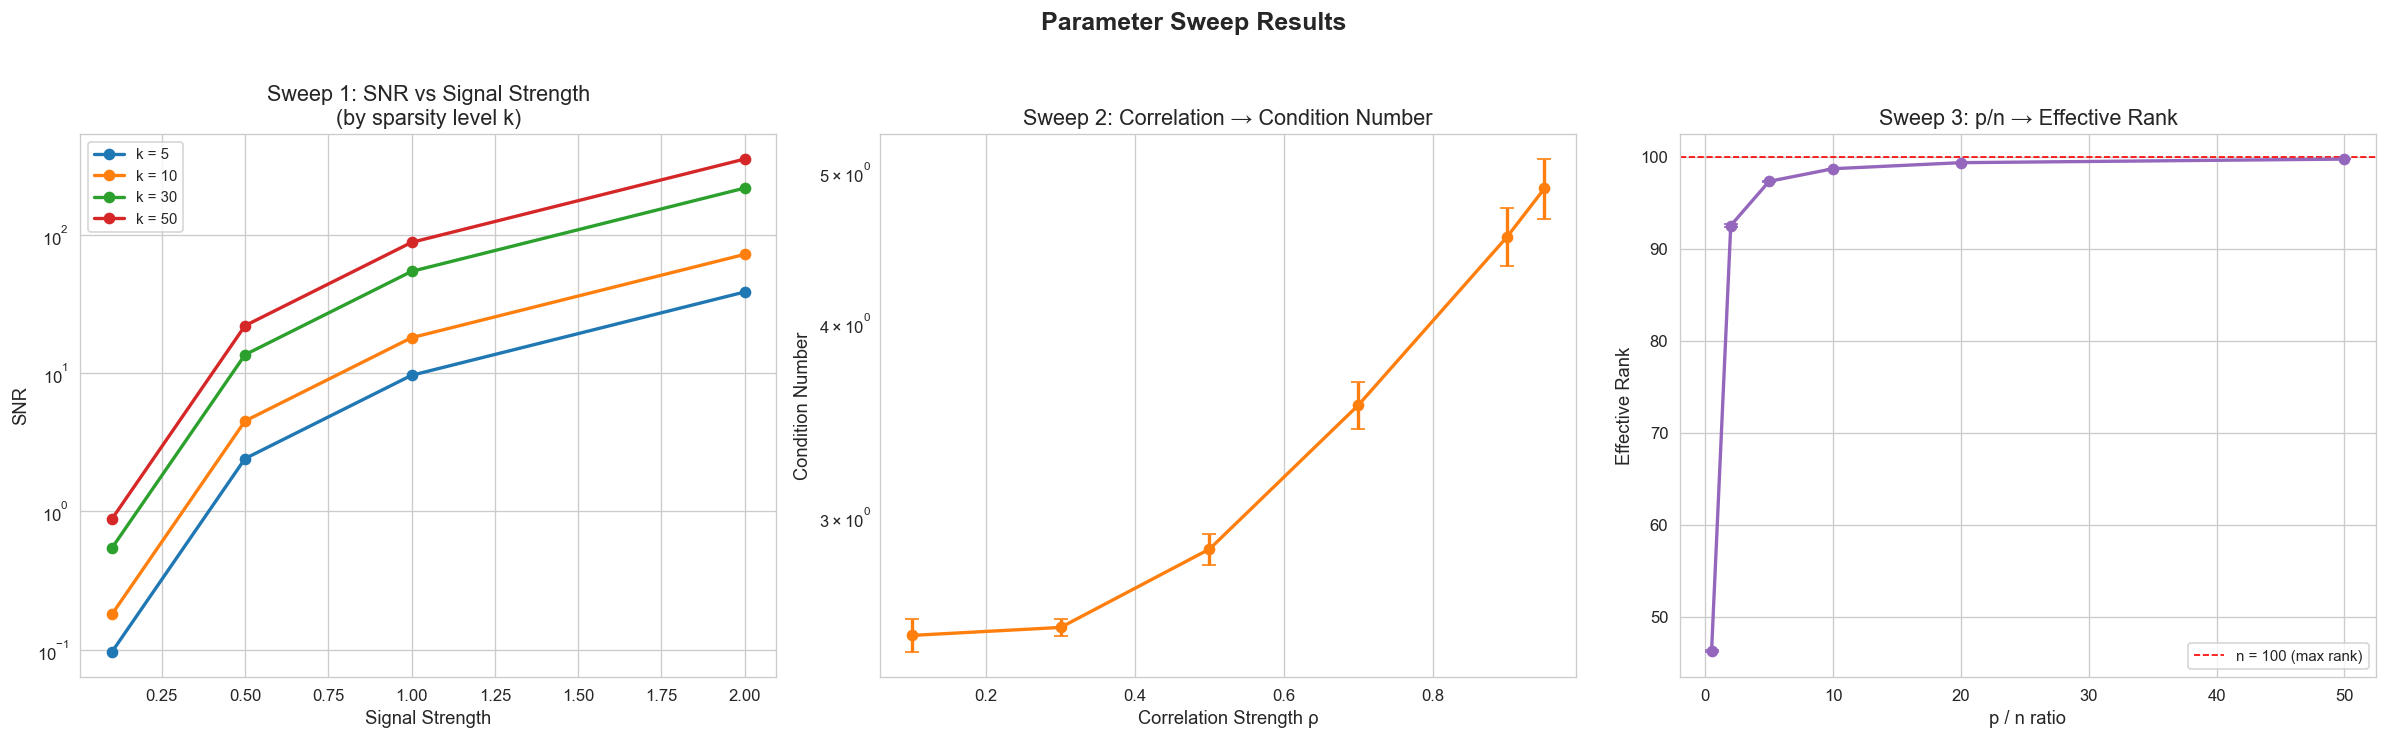

In [15]:
# ============================================================
# 4.1 — Parameter Sweep Visualisations
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# ── Sweep 1: SNR landscape ───────────────────────────────────
ax = axes[0]
for k_val in sorted(sweep1_df['k'].unique()):
    sub = sweep1_df[sweep1_df['k'] == k_val].groupby('signal_strength')['SNR'].mean()
    ax.plot(sub.index, sub.values, 'o-', label=f'k = {k_val}', lw=2)
ax.set_xlabel('Signal Strength')
ax.set_ylabel('SNR')
ax.set_title('Sweep 1: SNR vs Signal Strength\n(by sparsity level k)')
ax.legend()
ax.set_yscale('log')

# ── Sweep 2: Correlation → Condition Number ──────────────────
ax = axes[1]
agg2 = sweep2_df.groupby('correlation_strength')['condition_number'].agg(['mean', 'std'])
ax.errorbar(agg2.index, agg2['mean'], yerr=agg2['std'], fmt='o-', color='C1',
            capsize=4, lw=2)
ax.set_xlabel('Correlation Strength ρ')
ax.set_ylabel('Condition Number')
ax.set_title('Sweep 2: Correlation → Condition Number')
ax.set_yscale('log')

# ── Sweep 3: p/n → Effective Rank ───────────────────────────
ax = axes[2]
sweep3_df['p_over_n'] = sweep3_df['p'] / 100
agg3 = sweep3_df.groupby('p_over_n')['effective_rank'].agg(['mean', 'std'])
ax.errorbar(agg3.index, agg3['mean'], yerr=agg3['std'], fmt='o-', color='C4',
            capsize=4, lw=2)
ax.axhline(100, color='red', ls='--', lw=1, label='n = 100 (max rank)')
ax.set_xlabel('p / n ratio')
ax.set_ylabel('Effective Rank')
ax.set_title('Sweep 3: p/n → Effective Rank')
ax.legend()

plt.suptitle('Parameter Sweep Results', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

## 5 · Diagnostics Dashboard & Cross-Scenario Comparison

This section aggregates all 10 scenarios into a unified comparison, highlighting the structural differences that determine which regularisation method should be preferred.


In [16]:
# ============================================================
# 5.1 — Cross-Scenario Summary Table
# ============================================================

summary_rows = []
for name, res in ALL_SCENARIOS.items():
    d = res['diag']
    row = {
        'Scenario': name,
        'n': d['n'],
        'p': d['p'],
        'p/n': d['p_over_n'],
        'k (nonzero)': d['n_nonzero'],
        'Zero Frac.': d['zero_frac'],
        'SNR': d['SNR'],
        'Mean |corr|': d['mean_abs_corr'],
        'Cond. Number': d['condition_number'],
        'Eff. Rank': d['effective_rank'],
        'Gini(|β|)': d['gini'],
    }
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows).set_index('Scenario')

# Display with styling
styled = (
    summary_df.style
    .format(precision=3, na_rep='—')
    .background_gradient(cmap='YlOrRd', subset=['p/n'], axis=0)
    .background_gradient(cmap='Blues', subset=['SNR'], axis=0)
    .background_gradient(cmap='Purples', subset=['Mean |corr|'], axis=0)
    .background_gradient(cmap='Greens', subset=['Cond. Number'], axis=0)
    .set_caption('Cross-Scenario Diagnostic Summary')
)
display(styled)
print()
print(summary_df.to_string(float_format='{:.3f}'.format))

,n,p,p/n,k (nonzero),Zero Frac.,SNR,Mean |corr|,Cond. Number,Eff. Rank,Gini(|β|)
Scenario,,,,,,,,,,
True Sparse,100,500,5.000,10,0.980,21.516,0.080,2.530,97.340,0.983
Correlated Groups,100,500,5.000,10,0.980,23.505,0.086,3.910,95.780,0.983
Dense Signal,200,100,0.500,90,0.100,10.175,0.056,5.050,92.730,0.461
Weak Signal,100,500,5.000,10,0.980,0.018,0.080,2.530,97.340,0.980
Ultra High-Dim,100,5000,50.000,15,0.997,24.348,0.081,1.300,99.750,0.998
Block Correlation,200,200,1.000,12,0.940,8.653,0.249,3051.440,88.700,0.956
Heavy-Tailed Noise,200,100,0.500,10,0.900,21.633,0.056,5.050,92.730,0.921
Heteroskedastic,200,100,0.500,10,0.900,2.230,0.056,5.050,92.730,0.921
Non-Gaussian X,200,100,0.500,10,0.900,14.522,0.053,5.190,93.200,0.921



                       n     p    p/n  k (nonzero)  Zero Frac.    SNR  Mean |corr|  Cond. Number  Eff. Rank  Gini(|β|)
Scenario                                                                                                              
True Sparse          100   500  5.000           10       0.980 21.516        0.080         2.530     97.340      0.983
Correlated Groups    100   500  5.000           10       0.980 23.505        0.086         3.910     95.780      0.983
Dense Signal         200   100  0.500           90       0.100 10.175        0.056         5.050     92.730      0.461
Weak Signal          100   500  5.000           10       0.980  0.018        0.080         2.530     97.340      0.980
Ultra High-Dim       100  5000 50.000           15       0.997 24.348        0.081         1.300     99.750      0.998
Block Correlation    200   200  1.000           12       0.940  8.653        0.249      3051.440     88.700      0.956
Heavy-Tailed Noise   200   100  0.500          

C:\Users\karth\AppData\Local\Temp\ipykernel_18144\3115830428.py:70: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\karth\AppData\Local\Temp\ipykernel_18144\3115830428.py:70: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\karth\AppData\Local\Temp\ipykernel_18144\3115830428.py:71: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.savefig('scenario_dashboard.png', dpi=150, bbox_inches='tight')
C:\Users\karth\AppData\Local\Temp\ipykernel_18144\3115830428.py:71: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.savefig('scenario_dashboard.png', dpi=150, bbox_inches='tight')
c:\Users\karth\miniconda3\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\karth\miniconda3\envs\myenv\lib\site-packages\

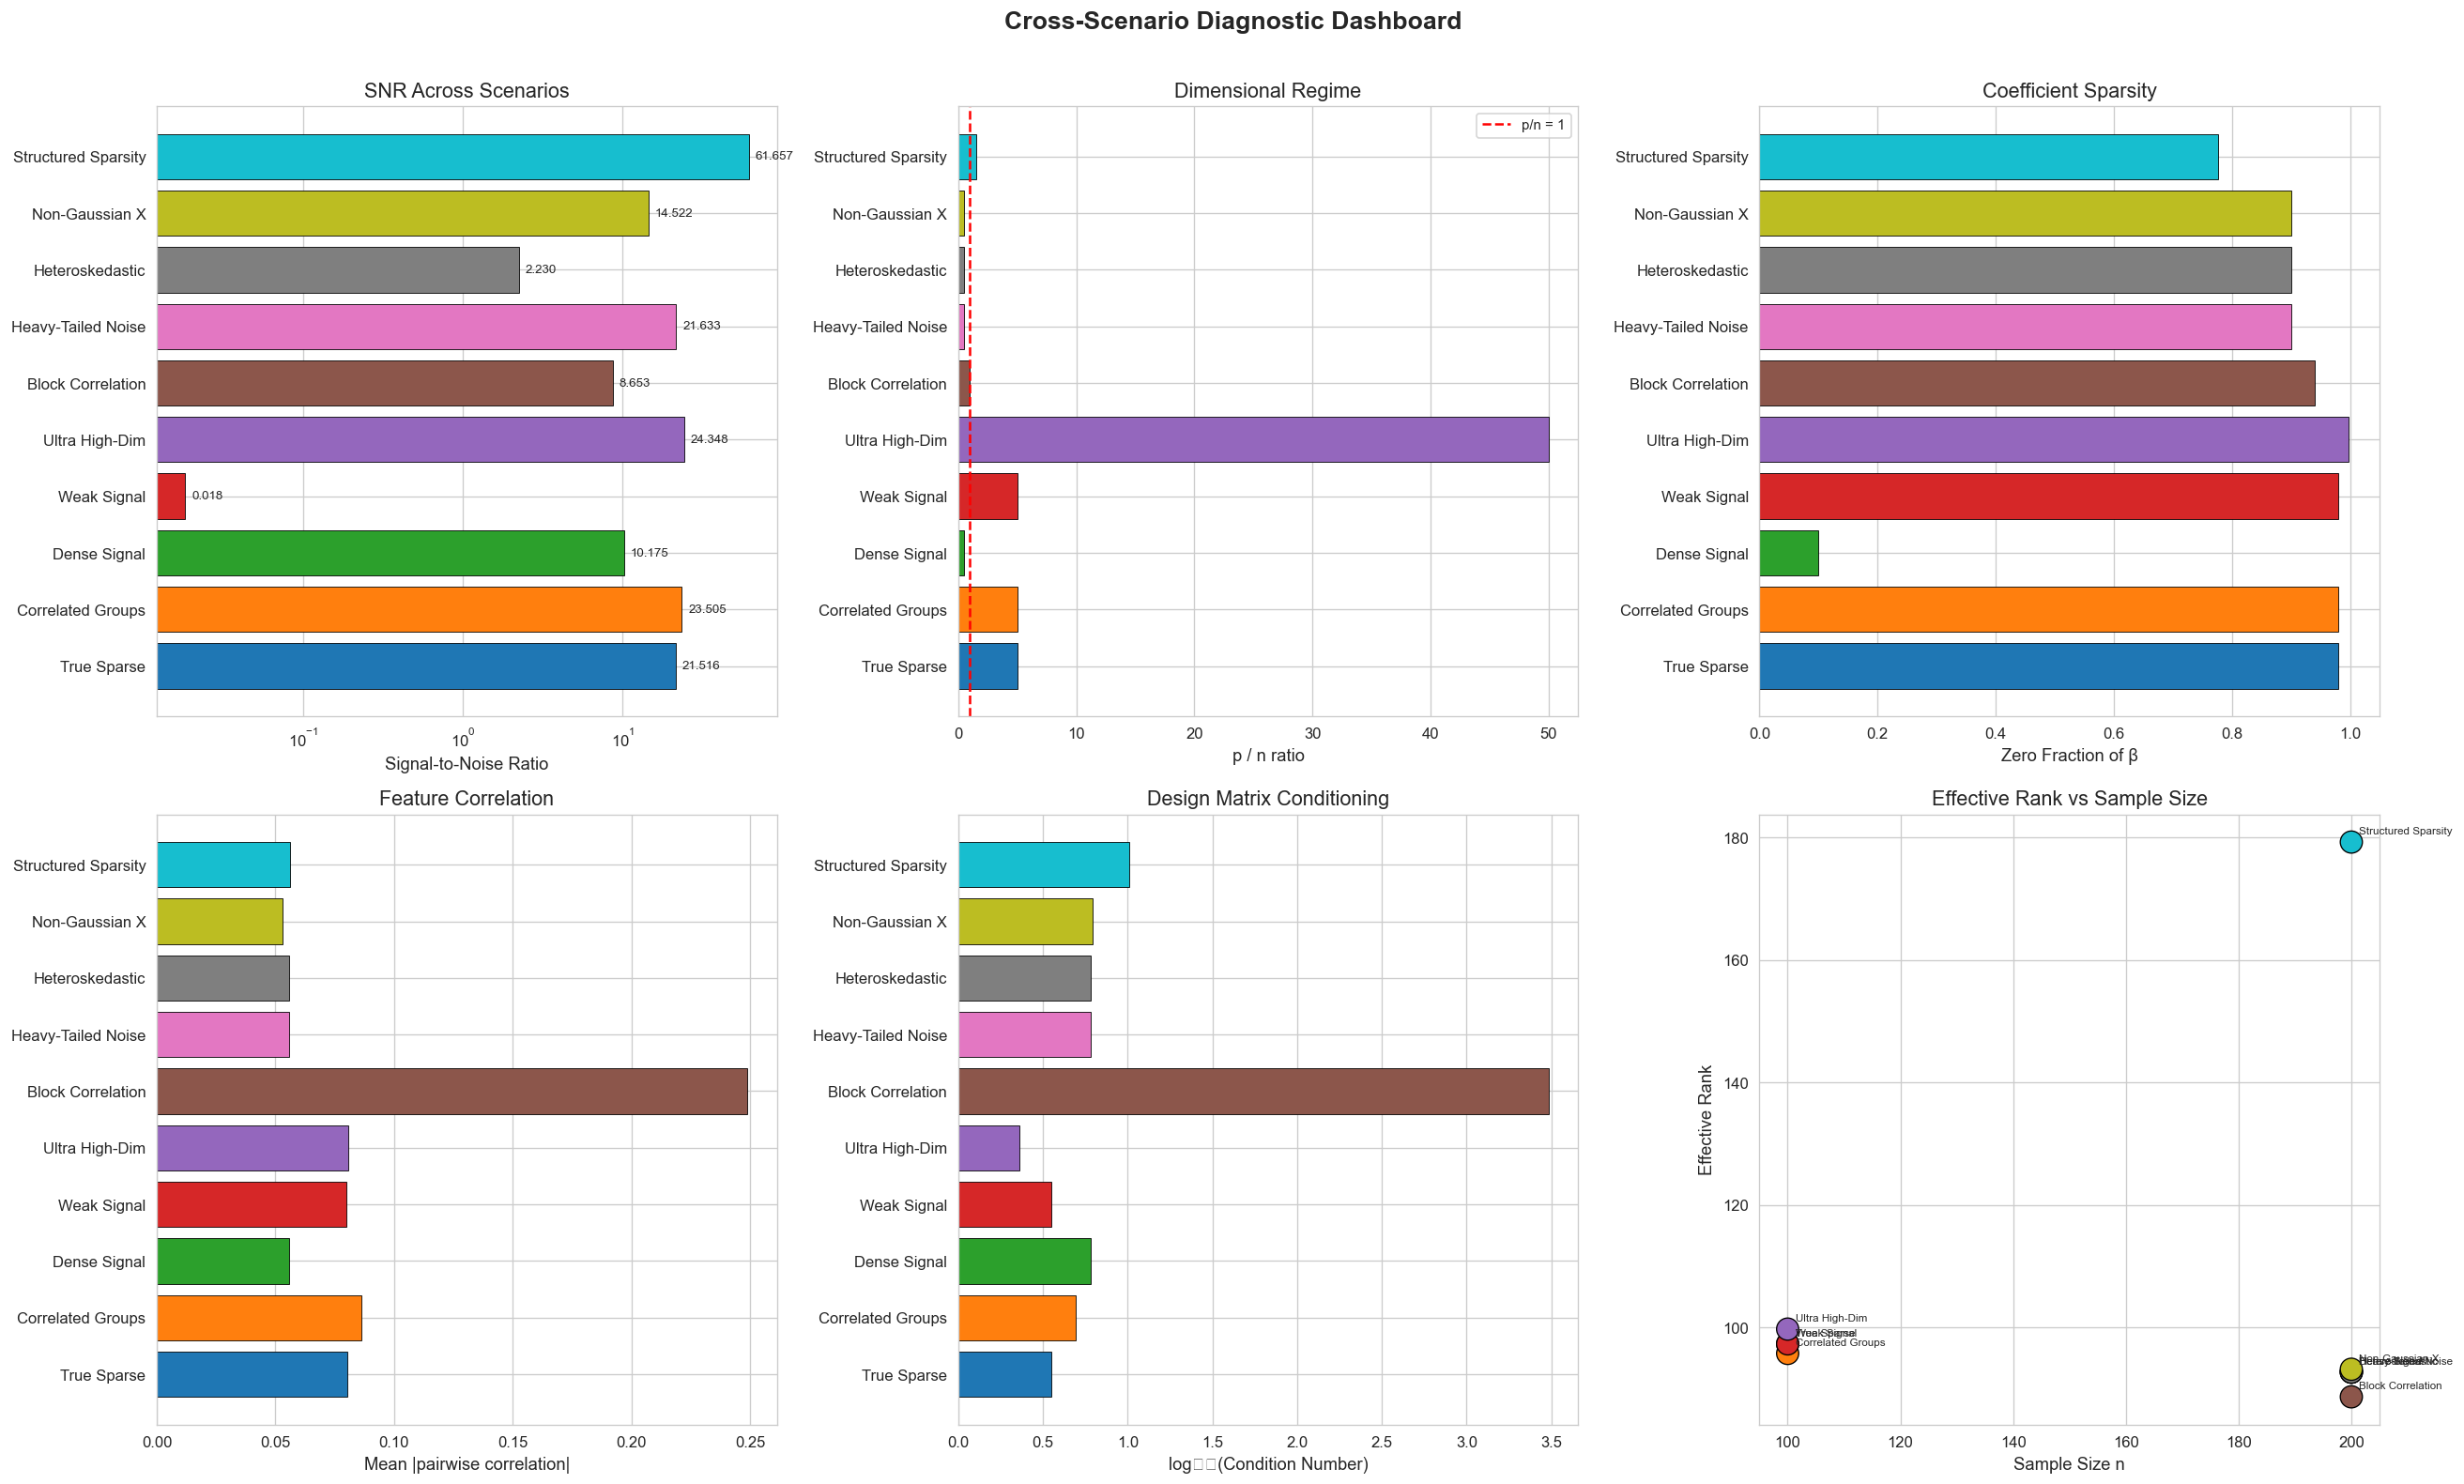

✅ Dashboard saved → scenario_dashboard.png


In [17]:
# ============================================================
# 5.2 — Multi-Panel Diagnostic Dashboard
# ============================================================

scenario_names = list(ALL_SCENARIOS.keys())
n_sc = len(scenario_names)
colors = [SCENARIO_COLORS.get(s, '#888888') for s in scenario_names]

fig, axes = plt.subplots(2, 3, figsize=(22, 13))

# ── Panel 1: SNR comparison ──────────────────────────────────
ax = axes[0, 0]
snrs = [ALL_SCENARIOS[s]['diag']['SNR'] for s in scenario_names]
bars = ax.barh(scenario_names, snrs, color=colors, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Signal-to-Noise Ratio')
ax.set_title('SNR Across Scenarios')
ax.set_xscale('log')
for bar, v in zip(bars, snrs):
    ax.text(max(v * 1.1, 0.001), bar.get_y() + bar.get_height()/2,
            f'{v:.3f}', va='center', fontsize=8)

# ── Panel 2: p/n ratio ──────────────────────────────────────
ax = axes[0, 1]
pn_ratios = [ALL_SCENARIOS[s]['diag']['p_over_n'] for s in scenario_names]
bars = ax.barh(scenario_names, pn_ratios, color=colors, edgecolor='black', linewidth=0.5)
ax.axvline(1.0, color='red', ls='--', lw=1.5, label='p/n = 1')
ax.set_xlabel('p / n ratio')
ax.set_title('Dimensional Regime')
ax.legend()

# ── Panel 3: Sparsity (zero fraction) ───────────────────────
ax = axes[0, 2]
zero_fracs = [ALL_SCENARIOS[s]['diag']['zero_frac'] for s in scenario_names]
bars = ax.barh(scenario_names, zero_fracs, color=colors, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Zero Fraction of β')
ax.set_title('Coefficient Sparsity')
ax.set_xlim(0, 1.05)

# ── Panel 4: Mean |correlation| ─────────────────────────────
ax = axes[1, 0]
mean_corrs = [ALL_SCENARIOS[s]['diag']['mean_abs_corr'] for s in scenario_names]
bars = ax.barh(scenario_names, mean_corrs, color=colors, edgecolor='black', linewidth=0.5)
ax.set_xlabel('Mean |pairwise correlation|')
ax.set_title('Feature Correlation')

# ── Panel 5: Condition Number (log scale) ────────────────────
ax = axes[1, 1]
cond_nums = []
for s in scenario_names:
    cn = ALL_SCENARIOS[s]['diag']['condition_number']
    cond_nums.append(cn if not np.isinf(cn) else 1e16)
bars = ax.barh(scenario_names, np.log10(np.array(cond_nums) + 1),
               color=colors, edgecolor='black', linewidth=0.5)
ax.set_xlabel('log₁₀(Condition Number)')
ax.set_title('Design Matrix Conditioning')

# ── Panel 6: Effective Rank vs n ─────────────────────────────
ax = axes[1, 2]
eff_ranks = [ALL_SCENARIOS[s]['diag']['effective_rank'] for s in scenario_names]
ns = [ALL_SCENARIOS[s]['diag']['n'] for s in scenario_names]
ax.scatter(ns, eff_ranks, s=200, c=colors, edgecolors='black', linewidths=0.8, zorder=3)
for i, s in enumerate(scenario_names):
    ax.annotate(s, (ns[i], eff_ranks[i]), fontsize=7,
                textcoords='offset points', xytext=(5, 5))
ax.set_xlabel('Sample Size n')
ax.set_ylabel('Effective Rank')
ax.set_title('Effective Rank vs Sample Size')

plt.suptitle('Cross-Scenario Diagnostic Dashboard', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('scenario_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Dashboard saved → scenario_dashboard.png')

C:\Users\karth\AppData\Local\Temp\ipykernel_18144\2392451517.py:40: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()


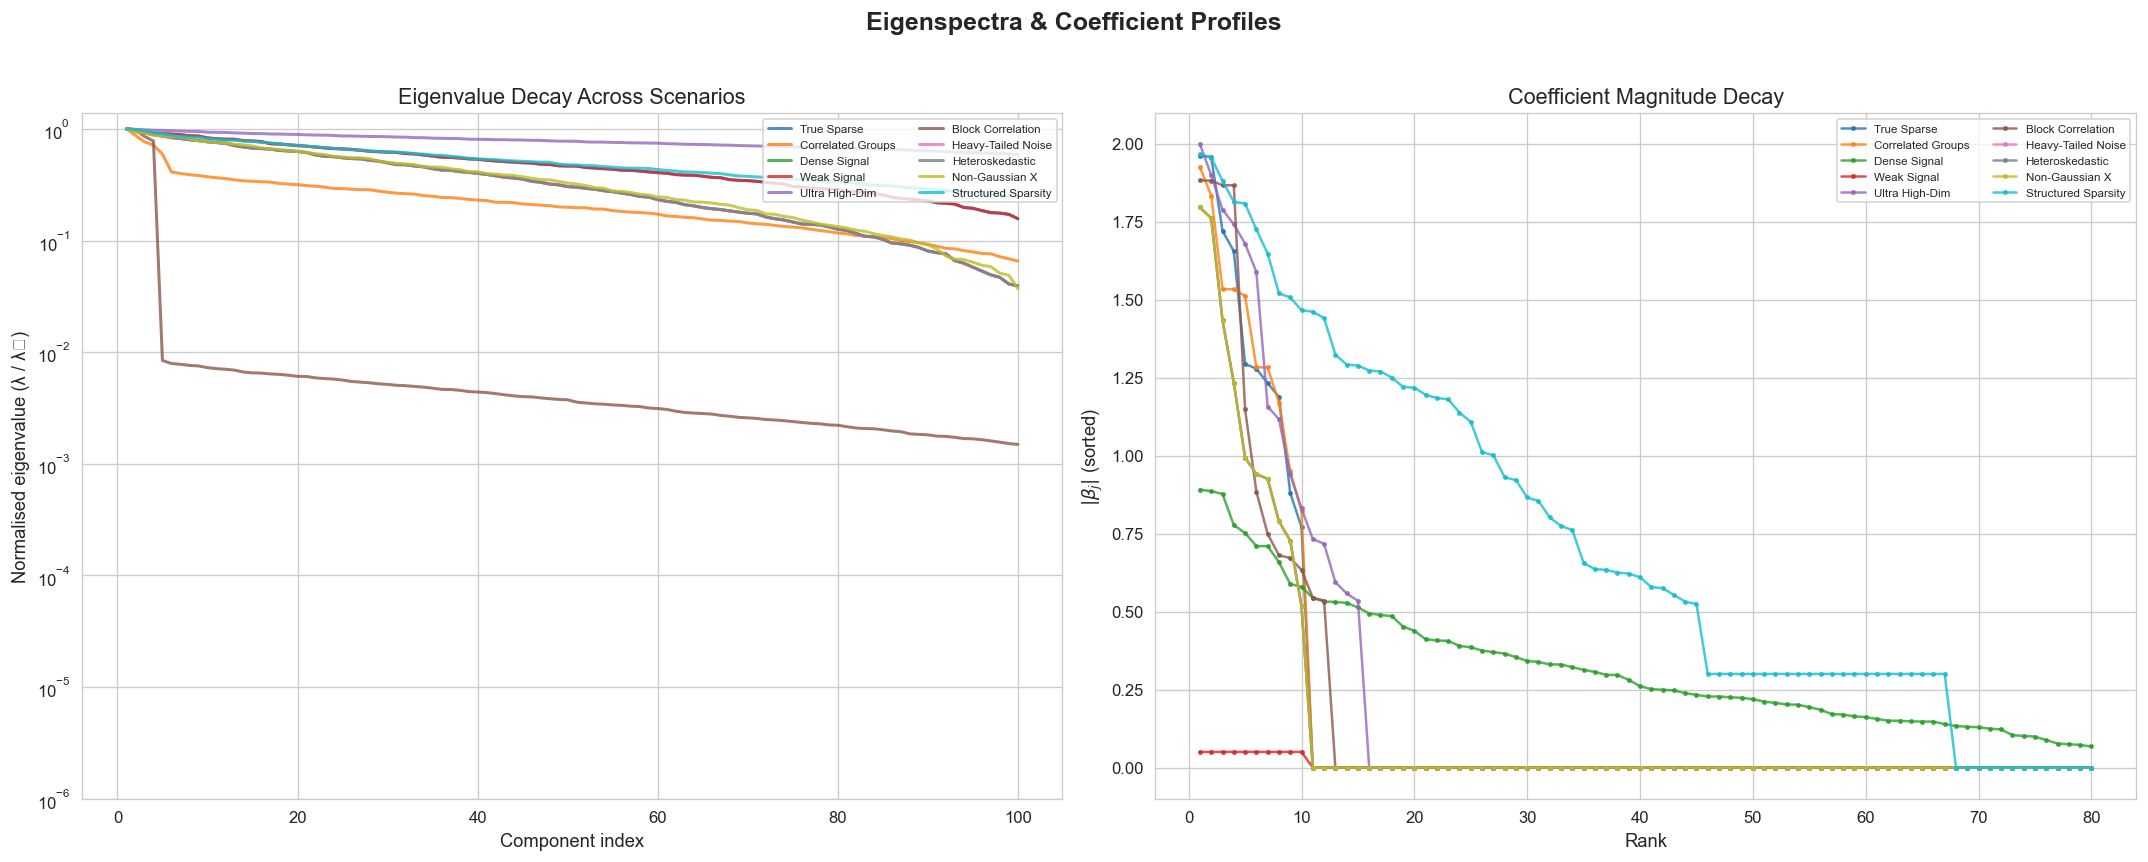

In [18]:
# ============================================================
# 5.3 — Eigenspectrum Overlay + β Comparison
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# ── (a) Eigenvalue decay curves (normalised) ─────────────────
ax = axes[0]
for i, name in enumerate(scenario_names):
    sv = ALL_SCENARIOS[name]['diag']['_sv']
    eig = sv ** 2
    eig_norm = eig / eig[0]  # normalise by largest
    n_plot = min(100, len(eig_norm))
    ax.plot(np.arange(1, n_plot+1), eig_norm[:n_plot],
            '-', lw=1.8, color=SCENARIO_COLORS.get(name, 'grey'),
            label=name, alpha=0.8)
ax.set_xlabel('Component index')
ax.set_ylabel('Normalised eigenvalue (λ / λ₁)')
ax.set_title('Eigenvalue Decay Across Scenarios')
ax.set_yscale('log')
ax.set_ylim(bottom=1e-6)
ax.legend(fontsize=7, ncol=2, loc='upper right')

# ── (b) β comparison: sorted |β| for each scenario ──────────
ax = axes[1]
for i, name in enumerate(scenario_names):
    beta = ALL_SCENARIOS[name]['beta']
    sorted_abs = np.sort(np.abs(beta))[::-1]
    n_plot = min(80, len(sorted_abs))
    ax.plot(np.arange(1, n_plot+1), sorted_abs[:n_plot],
            'o-', markersize=2, lw=1.5,
            color=SCENARIO_COLORS.get(name, 'grey'),
            label=name, alpha=0.8)
ax.set_xlabel('Rank')
ax.set_ylabel(r'$|\beta_j|$ (sorted)')
ax.set_title('Coefficient Magnitude Decay')
ax.legend(fontsize=7, ncol=2, loc='upper right')

plt.suptitle('Eigenspectra & Coefficient Profiles', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

## 6 · Dataset Export & Research Insights


In [19]:
# ============================================================
# 6.1 — Dataset Export
# ============================================================

def export_datasets(scenarios, output_dir='./synthetic_data/', fmt='npz'):
    """Save all synthetic datasets to disk.
    
    For each scenario, saves:
    - X, y, beta_true as arrays
    - metadata dict with diagnostics and generation parameters
    
    Supports .npz (numpy) and .csv (pandas) formats.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    manifest = []
    for name, res in scenarios.items():
        safe_name = name.lower().replace(' ', '_').replace('-', '_')
        
        # Serialisable metadata
        meta = {k: v for k, v in res['diag'].items() if not k.startswith('_')}
        meta['scenario'] = name
        meta['generation_params'] = str(res['params'])
        
        if fmt == 'npz':
            fpath = os.path.join(output_dir, f'{safe_name}.npz')
            np.savez_compressed(fpath,
                                X=res['X'], y=res['y'], beta_true=res['beta'])
            size_kb = os.path.getsize(fpath) / 1024
        elif fmt == 'csv':
            fpath_x = os.path.join(output_dir, f'{safe_name}_X.csv')
            fpath_y = os.path.join(output_dir, f'{safe_name}_y.csv')
            fpath_b = os.path.join(output_dir, f'{safe_name}_beta.csv')
            pd.DataFrame(res['X']).to_csv(fpath_x, index=False)
            pd.DataFrame({'y': res['y']}).to_csv(fpath_y, index=False)
            pd.DataFrame({'beta': res['beta']}).to_csv(fpath_b, index=False)
            size_kb = sum(os.path.getsize(f) for f in [fpath_x, fpath_y, fpath_b]) / 1024
            fpath = fpath_x  # for manifest
        else:
            raise ValueError(f"Unknown format: {fmt}")
        
        manifest.append({
            'Scenario': name,
            'File': os.path.basename(fpath),
            'n': res['diag']['n'],
            'p': res['diag']['p'],
            'Size (KB)': round(size_kb, 1),
        })
        print(f"  Saved: {fpath} ({size_kb:.1f} KB)")
    
    manifest_df = pd.DataFrame(manifest)
    total_size = manifest_df['Size (KB)'].sum()
    print(f"\n{'='*50}")
    print(f"  Total: {len(manifest)} datasets, {total_size:.1f} KB")
    print(f"{'='*50}")
    
    return manifest_df


def load_dataset(filepath):
    """Load a saved .npz dataset."""
    data = np.load(filepath)
    return {'X': data['X'], 'y': data['y'], 'beta': data['beta_true']}


# ── Export all scenarios ──────────────────────────────────────
print("Exporting all synthetic datasets...\n")
manifest = export_datasets(ALL_SCENARIOS, output_dir=CONFIG['output_dir'], fmt='npz')
display(manifest)

Exporting all synthetic datasets...

  Saved: ./synthetic_data/true_sparse.npz (376.8 KB)
  Saved: ./synthetic_data/correlated_groups.npz (376.8 KB)
  Saved: ./synthetic_data/dense_signal.npz (153.0 KB)
  Saved: ./synthetic_data/weak_signal.npz (376.7 KB)
  Saved: ./synthetic_data/ultra_high_dim.npz (3754.6 KB)
  Saved: ./synthetic_data/block_correlation.npz (302.3 KB)
  Saved: ./synthetic_data/heavy_tailed_noise.npz (152.4 KB)
  Saved: ./synthetic_data/heteroskedastic.npz (152.4 KB)
  Saved: ./synthetic_data/non_gaussian_x.npz (151.9 KB)
  Saved: ./synthetic_data/structured_sparsity.npz (452.9 KB)

  Total: 10 datasets, 6249.8 KB


,Scenario,File,n,p,Size (KB)
0,True Sparse,true_sparse.npz,100,500,376.8
1,Correlated Groups,correlated_groups.npz,100,500,376.8
2,Dense Signal,dense_signal.npz,200,100,153.0
3,Weak Signal,weak_signal.npz,100,500,376.7
4,Ultra High-Dim,ultra_high_dim.npz,100,5000,3754.6
5,Block Correlation,block_correlation.npz,200,200,302.3
6,Heavy-Tailed Noise,heavy_tailed_noise.npz,200,100,152.4
7,Heteroskedastic,heteroskedastic.npz,200,100,152.4
8,Non-Gaussian X,non_gaussian_x.npz,200,100,151.9
9,Structured Sparsity,structured_sparsity.npz,200,300,452.9


---

## 7 · Research Insights: Method–Scenario Suitability Map

The table below maps each synthetic scenario to the regularisation/shrinkage methods expected to perform best, based on the structural properties revealed by our diagnostics.

| Scenario                    | Best Methods                           | Why                                                                                 | Worst Methods                  | Why                                |
| :-------------------------- | :------------------------------------- | :---------------------------------------------------------------------------------- | :----------------------------- | :--------------------------------- |
| **1. True Sparse**          | Lasso, Horseshoe                       | Exact sparsity matches L1 geometry; Horseshoe's Cauchy tails preserve large signals | Ridge                          | Cannot zero out coefficients       |
| **2. Correlated Groups**    | Elastic Net, Horseshoe                 | EN grouping effect; Horseshoe shares posterior mass                                 | Lasso                          | Arbitrary selection within groups  |
| **3. Dense Signal**         | Ridge, Bayesian Ridge                  | James–Stein optimal shrinkage for dense β                                           | Lasso, Horseshoe               | Over-shrink small-but-nonzero β    |
| **4. Weak Signal**          | Horseshoe, Ridge                       | HS adaptive shrinkage; Ridge preserves all signals                                  | Lasso                          | Overshrinks → misses weak signals  |
| **5. Ultra High-Dim**       | Horseshoe, Lasso                       | HS global-local shrinkage; Lasso under compatibility                                | OLS (impossible), Ridge        | OLS singular; Ridge non-sparse     |
| **6. Block Correlation**    | Group Lasso, Elastic Net               | Explicit group structure; EN grouping                                               | Lasso                          | Irrepresentable violated in blocks |
| **7. Heavy-Tailed Noise**   | Robust Lasso (LAD)                     | Squared-loss methods sensitive to outliers                                          | All standard methods           | Gaussian likelihood misspecified   |
| **8. Heteroskedastic**      | Weighted methods, Bayes hierarchical   | Standard methods assume constant σ²                                                 | Unweighted Lasso/Ridge         | Inefficient estimates              |
| **9. Non-Gaussian X**       | All penalised methods (with caution)   | Sub-Gaussian theory may not hold                                                    | Theoretical guarantees fragile | Leverage points from skewed X      |
| **10. Structured Sparsity** | Sparse Group Lasso, Hierarchical Bayes | Matches DGP's group+within-group structure                                          | Standard Lasso                 | Ignores group structure            |

### Key Take-Aways

1. **No single method dominates all scenarios** — method choice should be driven by data structure.
2. **Sparsity level is the primary axis**: sparse → Lasso/Horseshoe; dense → Ridge.
3. **Correlation structure is the secondary axis**: high correlation → Elastic Net or Bayesian methods.
4. **SNR determines feasibility**: below SNR ≈ 0.1, all methods struggle; the question becomes false-positive control.
5. **p/n > 1 requires penalisation**: the choice between Lasso and Horseshoe depends on whether one trusts the Bayesian uncertainty quantification.
6. **Non-standard noise/features**: robustness is an orthogonal concern — consider robust loss functions or hierarchical Bayesian models.

### Design Principles for Benchmarking

- Always compare methods on **all 10 scenarios** to avoid selection bias.
- Report **SNR**, **condition number**, and **sparsity fraction** alongside performance metrics.
- Use the parameter sweep framework to identify **phase transitions** in method performance.
- The exported `.npz` files can be loaded directly for downstream method comparison.
